# Classifying cell types with neural networks

In this notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset for Shekhar et al., 2016. These cells have been manually annotated, and here we will show that a neural network can recapitulate these cell type labels.

## 1. Imports

In [1]:
!pip install scprep

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [3]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [4]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [5]:
data = scprep.reduce.pca(data_raw, n_components=100, method='dense').to_numpy()
data

array([[ -2.86639095,  16.11995588,   4.36943178, ...,  -1.92352617,
         -1.23398076,  -0.18499969],
       [ -0.66863206,  13.21553129,  -4.8926386 , ...,   2.2129324 ,
         -0.30849364,   2.33503532],
       [  0.29665496,   6.85551504,  18.19106778, ...,  -2.82630926,
          1.67045571,  -0.06871964],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.16420678, ...,  -0.89208505,
         -0.14628051,   2.41269496],
       [  3.13934964,  15.10619606,   3.69472732, ...,  -2.45809468,
         -2.331806  ,  -0.44193557],
       [ 42.90597659,  -9.79281524, -13.25214996, ...,  -0.15642158,
         -0.52714465,  -1.58145625]])

In [6]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

array([ 0,  1,  2, ..., 20, 20, 20])

In [7]:
num_classes = len(np.unique(labels))
num_classes

29

#### Splitting the data into training and validation sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [8]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

((17241, 100), (4311, 100))

## 3. Moving Our Data to PyTorch Tensors 

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available. 

In [9]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [10]:
# check shapes
print("train tensor shape: {}".format(train_tensor.shape))
print("train labels shape: {}".format(train_labels.shape))

print("valid tensor shape: {}".format(valid_tensor.shape))
print("valid labels shape: {}".format(valid_labels.shape))

train tensor shape: torch.Size([17241, 100])
train labels shape: torch.Size([17241])
valid tensor shape: torch.Size([4311, 100])
valid labels shape: torch.Size([4311])


## Exercise 1 - Tensor Operations 1

1. Create a tensor called x of values (1,20) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [11]:
# create x using torch.arange()
x = torch.arange(20)

# reshape to (4,5)
x = x.reshape(4,5)

# add 5
y = x + 5

# power y to the 3rd power
z = y ** 3

# print the first row of z
print(z[0])

tensor([125, 216, 343, 512, 729])


## Exercise 2 - Tensor Operations 2

1. Subset the training tensor by taking the last 5 rows

2. Double the values and print the result.


In [12]:
# Get the last five rows of `data_training`
data_last5 = train_tensor[-5:]

# Multiply by two
last5_double = train_tensor * 2

# Print the result
last5_double

tensor([[ -5.7328,  32.2399,   8.7389,  ...,  -3.8471,  -2.4680,  -0.3700],
        [ -1.3373,  26.4311,  -9.7853,  ...,   4.4259,  -0.6170,   4.6701],
        [  0.5933,  13.7110,  36.3821,  ...,  -5.6526,   3.3409,  -0.1374],
        ...,
        [-28.5883, -13.0283,  -4.1683,  ...,   3.1040,  -1.4847,  -1.4837],
        [ -1.0126,  31.4739,  -1.5407,  ...,   0.1357,   1.7186,  -5.8128],
        [-27.1728, -18.9764,   3.0928,  ...,   0.4251,   1.5037,  -4.0879]],
       dtype=torch.float64)

## 4. Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [13]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = torch.randn(input_size, output_size).double().requires_grad_()
        self.bias = torch.randn(output_size).double().requires_grad_()
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        output = self.activation(output)
        return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [14]:
input_size = data_training.shape[1]
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output

tensor([[ 9.9228e-72, 2.4956e-115,  2.6830e-45,  ...,  1.4393e-22,
          4.1317e-49,  1.1881e-87],
        [ 6.3094e-93, 9.0371e-143, 7.8264e-142,  ...,  3.3343e-74,
          1.0387e-40, 1.0014e-181],
        [ 1.5437e-37,  1.6377e-40,  8.0126e-59,  ...,  8.0852e-45,
          6.4936e-22,  2.6568e-89],
        ...,
        [ 1.9545e-36,  2.1544e-53,  4.9683e-29,  ...,  1.4466e-01,
          4.8434e-32,  5.3621e-31],
        [6.7169e-123, 2.6999e-169, 3.6800e-142,  ...,  6.3275e-63,
         1.6753e-116, 1.5895e-192],
        [ 8.9144e-40,  1.0835e-92,  5.5660e-25,  ...,  1.3610e-06,
          1.1614e-45,  1.4110e-58]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

#### Build the loss function

In order to train our neural network, we need to define a loss function which tells us how well (or how poorly) our classifier performed.

Here, we'll use the cross-entropy loss which we discussed in lecture.

In [15]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [16]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

tensor(400516.5197, dtype=torch.float64, grad_fn=<MulBackward0>)

#### Create the optimizer

PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [18]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.00001

optimizer = optim.SGD([layer_1.weight, layer_1.bias,
                       layer_2.weight, layer_2.bias],
                       lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 10

#### Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [19]:
# train the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(100):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        hidden_layer = layer_1(train_data_batch)
        output = layer_2(hidden_layer)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets every 50 steps
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_hidden = layer_1(valid_data_batch)
                    valid_output = layer_2(valid_hidden)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np = np.concatenate(prediction_np.reshape(-1,1), axis=0)
                    labels_np = np.concatenate(valid_labels_batch.numpy().reshape(-1,1), axis=0)


                # compute the accuracy over the whole dataset
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))
          

Step 50 loss: 205.678 training accuracy: 0.100 validation accuracy: 0.000 
Step 100 loss: 264.961 training accuracy: 0.000 validation accuracy: 0.000 
Step 150 loss: 250.261 training accuracy: 0.000 validation accuracy: 0.000 
Step 200 loss: 185.985 training accuracy: 0.100 validation accuracy: 0.100 
Step 250 loss: 234.498 training accuracy: 0.000 validation accuracy: 0.200 
Step 300 loss: 198.654 training accuracy: 0.100 validation accuracy: 0.000 
Step 350 loss: 222.733 training accuracy: 0.100 validation accuracy: 0.000 
Step 400 loss: 229.582 training accuracy: 0.100 validation accuracy: 0.000 
Step 450 loss: 245.975 training accuracy: 0.000 validation accuracy: 0.000 
Step 500 loss: 230.577 training accuracy: 0.100 validation accuracy: 0.000 
Step 550 loss: 238.413 training accuracy: 0.000 validation accuracy: 0.000 
Step 600 loss: 256.378 training accuracy: 0.000 validation accuracy: 0.000 
Step 650 loss: 224.726 training accuracy: 0.100 validation accuracy: 0.000 
Step 700 loss

Step 5450 loss: 207.248 training accuracy: 0.200 validation accuracy: 0.000 
Step 5500 loss: 248.336 training accuracy: 0.000 validation accuracy: 0.100 
Step 5550 loss: 160.579 training accuracy: 0.100 validation accuracy: 0.100 
Step 5600 loss: 192.799 training accuracy: 0.000 validation accuracy: 0.200 
Step 5650 loss: 204.210 training accuracy: 0.200 validation accuracy: 0.000 
Step 5700 loss: 233.586 training accuracy: 0.000 validation accuracy: 0.400 
Step 5750 loss: 168.838 training accuracy: 0.300 validation accuracy: 0.100 
Step 5800 loss: 199.416 training accuracy: 0.000 validation accuracy: 0.100 
Step 5850 loss: 166.934 training accuracy: 0.300 validation accuracy: 0.000 
Step 5900 loss: 254.490 training accuracy: 0.000 validation accuracy: 0.400 
Step 5950 loss: 206.046 training accuracy: 0.100 validation accuracy: 0.100 
Step 6000 loss: 157.774 training accuracy: 0.200 validation accuracy: 0.400 
Step 6050 loss: 178.978 training accuracy: 0.200 validation accuracy: 0.000 

Step 10850 loss: 213.400 training accuracy: 0.100 validation accuracy: 0.200 
Step 10900 loss: 200.191 training accuracy: 0.100 validation accuracy: 0.300 
Step 10950 loss: 144.062 training accuracy: 0.300 validation accuracy: 0.000 
Step 11000 loss: 205.563 training accuracy: 0.200 validation accuracy: 0.300 
Step 11050 loss: 154.955 training accuracy: 0.300 validation accuracy: 0.200 
Step 11100 loss: 228.372 training accuracy: 0.100 validation accuracy: 0.100 
Step 11150 loss: 210.897 training accuracy: 0.100 validation accuracy: 0.300 
Step 11200 loss: 249.984 training accuracy: 0.000 validation accuracy: 0.100 
Step 11250 loss: 164.515 training accuracy: 0.200 validation accuracy: 0.100 
Step 11300 loss: 145.344 training accuracy: 0.300 validation accuracy: 0.200 
Step 11350 loss: 175.694 training accuracy: 0.200 validation accuracy: 0.100 
Step 11400 loss: 193.875 training accuracy: 0.100 validation accuracy: 0.100 
Step 11450 loss: 215.421 training accuracy: 0.000 validation acc

Step 16250 loss: 204.019 training accuracy: 0.100 validation accuracy: 0.100 
Step 16300 loss: 159.880 training accuracy: 0.200 validation accuracy: 0.100 
Step 16350 loss: 224.673 training accuracy: 0.100 validation accuracy: 0.100 
Step 16400 loss: 175.672 training accuracy: 0.000 validation accuracy: 0.100 
Step 16450 loss: 230.643 training accuracy: 0.000 validation accuracy: 0.000 
Step 16500 loss: 187.117 training accuracy: 0.100 validation accuracy: 0.200 
Step 16550 loss: 205.314 training accuracy: 0.100 validation accuracy: 0.200 
Step 16600 loss: 137.476 training accuracy: 0.300 validation accuracy: 0.100 
Step 16650 loss: 212.733 training accuracy: 0.100 validation accuracy: 0.300 
Step 16700 loss: 247.148 training accuracy: 0.000 validation accuracy: 0.000 
Step 16750 loss: 181.910 training accuracy: 0.200 validation accuracy: 0.000 
Step 16800 loss: 210.402 training accuracy: 0.100 validation accuracy: 0.100 
Step 16850 loss: 200.178 training accuracy: 0.100 validation acc

Step 21650 loss: 169.262 training accuracy: 0.100 validation accuracy: 0.100 
Step 21700 loss: 170.151 training accuracy: 0.200 validation accuracy: 0.200 
Step 21750 loss: 182.487 training accuracy: 0.200 validation accuracy: 0.100 
Step 21800 loss: 203.678 training accuracy: 0.000 validation accuracy: 0.100 
Step 21850 loss: 225.449 training accuracy: 0.000 validation accuracy: 0.000 
Step 21900 loss: 195.168 training accuracy: 0.100 validation accuracy: 0.100 
Step 21950 loss: 159.502 training accuracy: 0.300 validation accuracy: 0.000 
Step 22000 loss: 145.133 training accuracy: 0.300 validation accuracy: 0.000 
Step 22050 loss: 201.482 training accuracy: 0.100 validation accuracy: 0.100 
Step 22100 loss: 232.714 training accuracy: 0.000 validation accuracy: 0.000 
Step 22150 loss: 214.595 training accuracy: 0.100 validation accuracy: 0.100 
Step 22200 loss: 210.552 training accuracy: 0.100 validation accuracy: 0.000 
Step 22250 loss: 172.174 training accuracy: 0.200 validation acc

Step 26950 loss: 216.184 training accuracy: 0.000 validation accuracy: 0.000 
Step 27000 loss: 176.124 training accuracy: 0.100 validation accuracy: 0.300 
Step 27050 loss: 199.561 training accuracy: 0.100 validation accuracy: 0.300 
Step 27100 loss: 196.155 training accuracy: 0.200 validation accuracy: 0.100 
Step 27150 loss: 128.088 training accuracy: 0.300 validation accuracy: 0.100 
Step 27200 loss: 123.548 training accuracy: 0.300 validation accuracy: 0.100 
Step 27250 loss: 193.022 training accuracy: 0.100 validation accuracy: 0.100 
Step 27300 loss: 193.798 training accuracy: 0.100 validation accuracy: 0.100 
Step 27350 loss: 194.044 training accuracy: 0.000 validation accuracy: 0.000 
Step 27400 loss: 154.148 training accuracy: 0.200 validation accuracy: 0.100 
Step 27450 loss: 212.985 training accuracy: 0.000 validation accuracy: 0.100 
Step 27500 loss: 203.479 training accuracy: 0.000 validation accuracy: 0.300 
Step 27550 loss: 195.491 training accuracy: 0.100 validation acc

Step 32250 loss: 138.230 training accuracy: 0.200 validation accuracy: 0.100 
Step 32300 loss: 171.001 training accuracy: 0.100 validation accuracy: 0.300 
Step 32350 loss: 182.184 training accuracy: 0.100 validation accuracy: 0.100 
Step 32400 loss: 182.853 training accuracy: 0.100 validation accuracy: 0.100 
Step 32450 loss: 216.225 training accuracy: 0.000 validation accuracy: 0.100 
Step 32500 loss: 210.885 training accuracy: 0.000 validation accuracy: 0.100 
Step 32550 loss: 185.022 training accuracy: 0.200 validation accuracy: 0.100 
Step 32600 loss: 207.471 training accuracy: 0.000 validation accuracy: 0.000 
Step 32650 loss: 191.670 training accuracy: 0.100 validation accuracy: 0.200 
Step 32700 loss: 190.050 training accuracy: 0.100 validation accuracy: 0.500 
Step 32750 loss: 186.456 training accuracy: 0.100 validation accuracy: 0.100 
Step 32800 loss: 186.992 training accuracy: 0.100 validation accuracy: 0.000 
Step 32850 loss: 209.496 training accuracy: 0.100 validation acc

Step 37600 loss: 140.924 training accuracy: 0.200 validation accuracy: 0.100 
Step 37650 loss: 171.102 training accuracy: 0.300 validation accuracy: 0.000 
Step 37700 loss: 235.260 training accuracy: 0.000 validation accuracy: 0.100 
Step 37750 loss: 193.355 training accuracy: 0.100 validation accuracy: 0.100 
Step 37800 loss: 175.783 training accuracy: 0.200 validation accuracy: 0.000 
Step 37850 loss: 188.552 training accuracy: 0.100 validation accuracy: 0.200 
Step 37900 loss: 149.172 training accuracy: 0.100 validation accuracy: 0.100 
Step 37950 loss: 201.884 training accuracy: 0.100 validation accuracy: 0.100 
Step 38000 loss: 203.417 training accuracy: 0.100 validation accuracy: 0.100 
Step 38050 loss: 193.881 training accuracy: 0.100 validation accuracy: 0.100 
Step 38100 loss: 142.269 training accuracy: 0.300 validation accuracy: 0.000 
Step 38150 loss: 192.411 training accuracy: 0.100 validation accuracy: 0.000 
Step 38200 loss: 196.821 training accuracy: 0.100 validation acc

Step 42950 loss: 210.673 training accuracy: 0.000 validation accuracy: 0.100 
Step 43000 loss: 158.512 training accuracy: 0.100 validation accuracy: 0.000 
Step 43050 loss: 167.561 training accuracy: 0.200 validation accuracy: 0.100 
Step 43100 loss: 231.093 training accuracy: 0.000 validation accuracy: 0.100 
Step 43150 loss: 161.164 training accuracy: 0.100 validation accuracy: 0.100 
Step 43200 loss: 189.800 training accuracy: 0.000 validation accuracy: 0.300 
Step 43250 loss: 197.221 training accuracy: 0.000 validation accuracy: 0.100 
Step 43300 loss: 164.365 training accuracy: 0.100 validation accuracy: 0.000 
Step 43350 loss: 123.915 training accuracy: 0.300 validation accuracy: 0.400 
Step 43400 loss: 135.782 training accuracy: 0.400 validation accuracy: 0.100 
Step 43450 loss: 201.906 training accuracy: 0.000 validation accuracy: 0.100 
Step 43500 loss: 212.595 training accuracy: 0.000 validation accuracy: 0.100 
Step 43550 loss: 216.537 training accuracy: 0.000 validation acc

Step 48350 loss: 112.675 training accuracy: 0.300 validation accuracy: 0.100 
Step 48400 loss: 158.751 training accuracy: 0.200 validation accuracy: 0.000 
Step 48450 loss: 201.640 training accuracy: 0.000 validation accuracy: 0.100 
Step 48500 loss: 162.452 training accuracy: 0.200 validation accuracy: 0.000 
Step 48550 loss: 229.019 training accuracy: 0.000 validation accuracy: 0.000 
Step 48600 loss: 178.061 training accuracy: 0.100 validation accuracy: 0.000 
Step 48650 loss: 188.083 training accuracy: 0.000 validation accuracy: 0.300 
Step 48700 loss: 165.459 training accuracy: 0.100 validation accuracy: 0.300 
Step 48750 loss: 213.677 training accuracy: 0.000 validation accuracy: 0.100 
Step 48800 loss: 101.173 training accuracy: 0.400 validation accuracy: 0.600 
Step 48850 loss: 168.645 training accuracy: 0.000 validation accuracy: 0.200 
Step 48900 loss: 172.302 training accuracy: 0.100 validation accuracy: 0.100 
Step 48950 loss: 208.370 training accuracy: 0.000 validation acc

Step 53750 loss: 180.753 training accuracy: 0.000 validation accuracy: 0.300 
Step 53800 loss: 184.999 training accuracy: 0.000 validation accuracy: 0.200 
Step 53850 loss: 163.162 training accuracy: 0.100 validation accuracy: 0.300 
Step 53900 loss: 123.528 training accuracy: 0.300 validation accuracy: 0.000 
Step 53950 loss: 153.601 training accuracy: 0.200 validation accuracy: 0.100 
Step 54000 loss: 189.767 training accuracy: 0.100 validation accuracy: 0.200 
Step 54050 loss: 147.822 training accuracy: 0.200 validation accuracy: 0.300 
Step 54100 loss: 131.527 training accuracy: 0.400 validation accuracy: 0.000 
Step 54150 loss: 152.789 training accuracy: 0.200 validation accuracy: 0.100 
Step 54200 loss: 215.153 training accuracy: 0.000 validation accuracy: 0.300 
Step 54250 loss: 184.762 training accuracy: 0.000 validation accuracy: 0.200 
Step 54300 loss: 177.008 training accuracy: 0.000 validation accuracy: 0.000 
Step 54350 loss: 169.384 training accuracy: 0.200 validation acc

Step 59100 loss: 193.729 training accuracy: 0.000 validation accuracy: 0.200 
Step 59150 loss: 197.579 training accuracy: 0.000 validation accuracy: 0.100 
Step 59200 loss: 123.469 training accuracy: 0.300 validation accuracy: 0.300 
Step 59250 loss: 198.958 training accuracy: 0.000 validation accuracy: 0.200 
Step 59300 loss: 141.995 training accuracy: 0.100 validation accuracy: 0.000 
Step 59350 loss: 174.344 training accuracy: 0.100 validation accuracy: 0.100 
Step 59400 loss: 154.322 training accuracy: 0.100 validation accuracy: 0.300 
Step 59450 loss: 108.732 training accuracy: 0.400 validation accuracy: 0.200 
Step 59500 loss: 175.186 training accuracy: 0.100 validation accuracy: 0.100 
Step 59550 loss: 192.817 training accuracy: 0.000 validation accuracy: 0.300 
Step 59600 loss: 170.401 training accuracy: 0.000 validation accuracy: 0.000 
Step 59650 loss: 176.876 training accuracy: 0.000 validation accuracy: 0.200 
Step 59700 loss: 139.923 training accuracy: 0.300 validation acc

Step 64450 loss: 96.646 training accuracy: 0.300 validation accuracy: 0.200 
Step 64500 loss: 173.007 training accuracy: 0.100 validation accuracy: 0.100 
Step 64550 loss: 94.654 training accuracy: 0.400 validation accuracy: 0.100 
Step 64600 loss: 167.581 training accuracy: 0.100 validation accuracy: 0.200 
Step 64650 loss: 202.118 training accuracy: 0.000 validation accuracy: 0.300 
Step 64700 loss: 177.065 training accuracy: 0.100 validation accuracy: 0.600 
Step 64750 loss: 151.346 training accuracy: 0.000 validation accuracy: 0.100 
Step 64800 loss: 100.884 training accuracy: 0.400 validation accuracy: 0.000 
Step 64850 loss: 189.329 training accuracy: 0.000 validation accuracy: 0.000 
Step 64900 loss: 154.446 training accuracy: 0.200 validation accuracy: 0.000 
Step 64950 loss: 137.928 training accuracy: 0.200 validation accuracy: 0.100 
Step 65000 loss: 146.262 training accuracy: 0.000 validation accuracy: 0.000 
Step 65050 loss: 179.968 training accuracy: 0.100 validation accur

Step 69850 loss: 140.149 training accuracy: 0.200 validation accuracy: 0.100 
Step 69900 loss: 133.560 training accuracy: 0.200 validation accuracy: 0.100 
Step 69950 loss: 126.963 training accuracy: 0.200 validation accuracy: 0.100 
Step 70000 loss: 120.148 training accuracy: 0.400 validation accuracy: 0.000 
Step 70050 loss: 145.380 training accuracy: 0.000 validation accuracy: 0.100 
Step 70100 loss: 172.497 training accuracy: 0.100 validation accuracy: 0.000 
Step 70150 loss: 166.137 training accuracy: 0.000 validation accuracy: 0.200 
Step 70200 loss: 129.996 training accuracy: 0.200 validation accuracy: 0.000 
Step 70250 loss: 164.522 training accuracy: 0.000 validation accuracy: 0.200 
Step 70300 loss: 89.559 training accuracy: 0.300 validation accuracy: 0.200 
Step 70350 loss: 147.614 training accuracy: 0.100 validation accuracy: 0.300 
Step 70400 loss: 100.720 training accuracy: 0.300 validation accuracy: 0.000 
Step 70450 loss: 116.434 training accuracy: 0.200 validation accu

Step 75250 loss: 137.198 training accuracy: 0.100 validation accuracy: 0.200 
Step 75300 loss: 142.045 training accuracy: 0.100 validation accuracy: 0.200 
Step 75350 loss: 165.678 training accuracy: 0.000 validation accuracy: 0.200 
Step 75400 loss: 119.247 training accuracy: 0.200 validation accuracy: 0.200 
Step 75450 loss: 123.103 training accuracy: 0.200 validation accuracy: 0.100 
Step 75500 loss: 117.162 training accuracy: 0.200 validation accuracy: 0.200 
Step 75550 loss: 159.274 training accuracy: 0.200 validation accuracy: 0.100 
Step 75600 loss: 166.880 training accuracy: 0.000 validation accuracy: 0.100 
Step 75650 loss: 85.052 training accuracy: 0.400 validation accuracy: 0.400 
Step 75700 loss: 149.480 training accuracy: 0.200 validation accuracy: 0.300 
Step 75750 loss: 149.331 training accuracy: 0.200 validation accuracy: 0.200 
Step 75800 loss: 163.265 training accuracy: 0.000 validation accuracy: 0.300 
Step 75850 loss: 121.438 training accuracy: 0.200 validation accu

Step 80600 loss: 121.708 training accuracy: 0.200 validation accuracy: 0.400 
Step 80650 loss: 92.267 training accuracy: 0.500 validation accuracy: 0.000 
Step 80700 loss: 130.181 training accuracy: 0.100 validation accuracy: 0.200 
Step 80750 loss: 181.617 training accuracy: 0.000 validation accuracy: 0.400 
Step 80800 loss: 133.584 training accuracy: 0.100 validation accuracy: 0.100 
Step 80850 loss: 128.447 training accuracy: 0.100 validation accuracy: 0.300 
Step 80900 loss: 160.365 training accuracy: 0.100 validation accuracy: 0.100 
Step 80950 loss: 150.614 training accuracy: 0.000 validation accuracy: 0.400 
Step 81000 loss: 116.765 training accuracy: 0.100 validation accuracy: 0.600 
Step 81050 loss: 96.028 training accuracy: 0.300 validation accuracy: 0.300 
Step 81100 loss: 117.668 training accuracy: 0.200 validation accuracy: 0.200 
Step 81150 loss: 137.881 training accuracy: 0.100 validation accuracy: 0.300 
Step 81200 loss: 137.740 training accuracy: 0.100 validation accur

Step 86000 loss: 98.003 training accuracy: 0.400 validation accuracy: 0.000 
Step 86050 loss: 103.729 training accuracy: 0.300 validation accuracy: 0.300 
Step 86100 loss: 116.225 training accuracy: 0.200 validation accuracy: 0.300 
Step 86150 loss: 122.703 training accuracy: 0.200 validation accuracy: 0.100 
Step 86200 loss: 108.453 training accuracy: 0.400 validation accuracy: 0.200 
Step 86250 loss: 71.823 training accuracy: 0.500 validation accuracy: 0.400 
Step 86300 loss: 113.627 training accuracy: 0.300 validation accuracy: 0.200 
Step 86350 loss: 107.276 training accuracy: 0.300 validation accuracy: 0.000 
Step 86400 loss: 77.426 training accuracy: 0.500 validation accuracy: 0.100 
Step 86450 loss: 168.496 training accuracy: 0.000 validation accuracy: 0.200 
Step 86500 loss: 151.050 training accuracy: 0.100 validation accuracy: 0.200 
Step 86550 loss: 108.690 training accuracy: 0.200 validation accuracy: 0.200 
Step 86600 loss: 62.307 training accuracy: 0.500 validation accurac

Step 91400 loss: 60.835 training accuracy: 0.700 validation accuracy: 0.400 
Step 91450 loss: 109.718 training accuracy: 0.200 validation accuracy: 0.300 
Step 91500 loss: 116.552 training accuracy: 0.300 validation accuracy: 0.100 
Step 91550 loss: 86.682 training accuracy: 0.500 validation accuracy: 0.300 
Step 91600 loss: 73.496 training accuracy: 0.400 validation accuracy: 0.400 
Step 91650 loss: 77.282 training accuracy: 0.500 validation accuracy: 0.200 
Step 91700 loss: 81.182 training accuracy: 0.500 validation accuracy: 0.400 
Step 91750 loss: 94.117 training accuracy: 0.300 validation accuracy: 0.100 
Step 91800 loss: 60.237 training accuracy: 0.500 validation accuracy: 0.300 
Step 91850 loss: 100.165 training accuracy: 0.300 validation accuracy: 0.100 
Step 91900 loss: 84.943 training accuracy: 0.300 validation accuracy: 0.400 
Step 91950 loss: 29.131 training accuracy: 0.600 validation accuracy: 0.100 
Step 92000 loss: 109.674 training accuracy: 0.200 validation accuracy: 0.

Step 96800 loss: 88.700 training accuracy: 0.500 validation accuracy: 0.400 
Step 96850 loss: 87.811 training accuracy: 0.500 validation accuracy: 0.200 
Step 96900 loss: 92.589 training accuracy: 0.400 validation accuracy: 0.100 
Step 96950 loss: 116.224 training accuracy: 0.400 validation accuracy: 0.100 
Step 97000 loss: 93.166 training accuracy: 0.400 validation accuracy: 0.100 
Step 97050 loss: 147.660 training accuracy: 0.100 validation accuracy: 0.300 
Step 97100 loss: 78.540 training accuracy: 0.500 validation accuracy: 0.600 
Step 97150 loss: 76.203 training accuracy: 0.500 validation accuracy: 0.300 
Step 97200 loss: 88.476 training accuracy: 0.500 validation accuracy: 0.500 
Step 97250 loss: 79.677 training accuracy: 0.500 validation accuracy: 0.400 
Step 97300 loss: 79.598 training accuracy: 0.400 validation accuracy: 0.300 
Step 97350 loss: 128.391 training accuracy: 0.400 validation accuracy: 0.300 
Step 97400 loss: 73.544 training accuracy: 0.500 validation accuracy: 0.1

Step 102200 loss: 80.876 training accuracy: 0.500 validation accuracy: 0.200 
Step 102250 loss: 62.346 training accuracy: 0.600 validation accuracy: 0.300 
Step 102300 loss: 137.028 training accuracy: 0.100 validation accuracy: 0.300 
Step 102350 loss: 138.875 training accuracy: 0.200 validation accuracy: 0.100 
Step 102400 loss: 93.672 training accuracy: 0.300 validation accuracy: 0.300 
Step 102450 loss: 97.312 training accuracy: 0.400 validation accuracy: 0.500 
Step 102500 loss: 73.944 training accuracy: 0.500 validation accuracy: 0.200 
Step 102550 loss: 90.758 training accuracy: 0.500 validation accuracy: 0.100 
Step 102600 loss: 45.566 training accuracy: 0.700 validation accuracy: 0.400 
Step 102650 loss: 91.403 training accuracy: 0.400 validation accuracy: 0.200 
Step 102700 loss: 122.464 training accuracy: 0.400 validation accuracy: 0.200 
Step 102750 loss: 187.190 training accuracy: 0.100 validation accuracy: 0.300 
Step 102800 loss: 45.482 training accuracy: 0.700 validation

Step 107450 loss: 51.573 training accuracy: 0.700 validation accuracy: 0.400 
Step 107500 loss: 111.455 training accuracy: 0.300 validation accuracy: 0.200 
Step 107550 loss: 100.612 training accuracy: 0.300 validation accuracy: 0.000 
Step 107600 loss: 47.304 training accuracy: 0.700 validation accuracy: 0.500 
Step 107650 loss: 33.800 training accuracy: 0.800 validation accuracy: 0.400 
Step 107700 loss: 32.544 training accuracy: 0.800 validation accuracy: 0.200 
Step 107750 loss: 47.164 training accuracy: 0.700 validation accuracy: 0.300 
Step 107800 loss: 92.683 training accuracy: 0.400 validation accuracy: 0.500 
Step 107850 loss: 62.140 training accuracy: 0.600 validation accuracy: 0.400 
Step 107900 loss: 91.176 training accuracy: 0.500 validation accuracy: 0.400 
Step 107950 loss: 31.862 training accuracy: 0.800 validation accuracy: 0.300 
Step 108000 loss: 77.216 training accuracy: 0.500 validation accuracy: 0.400 
Step 108050 loss: 27.991 training accuracy: 0.900 validation a

Step 112700 loss: 106.494 training accuracy: 0.300 validation accuracy: 0.600 
Step 112750 loss: 134.182 training accuracy: 0.100 validation accuracy: 0.100 
Step 112800 loss: 53.114 training accuracy: 0.600 validation accuracy: 0.300 
Step 112850 loss: 82.454 training accuracy: 0.400 validation accuracy: 0.400 
Step 112900 loss: 50.596 training accuracy: 0.600 validation accuracy: 0.200 
Step 112950 loss: 101.618 training accuracy: 0.400 validation accuracy: 0.600 
Step 113000 loss: 61.937 training accuracy: 0.600 validation accuracy: 0.400 
Step 113050 loss: 71.175 training accuracy: 0.500 validation accuracy: 0.300 
Step 113100 loss: 105.410 training accuracy: 0.400 validation accuracy: 0.700 
Step 113150 loss: 31.310 training accuracy: 0.800 validation accuracy: 0.300 
Step 113200 loss: 126.121 training accuracy: 0.300 validation accuracy: 0.300 
Step 113250 loss: 78.042 training accuracy: 0.500 validation accuracy: 0.300 
Step 113300 loss: 69.102 training accuracy: 0.500 validatio

Step 117950 loss: 77.899 training accuracy: 0.500 validation accuracy: 0.700 
Step 118000 loss: 47.334 training accuracy: 0.700 validation accuracy: 0.500 
Step 118050 loss: 110.114 training accuracy: 0.300 validation accuracy: 0.100 
Step 118100 loss: 40.958 training accuracy: 0.800 validation accuracy: 0.400 
Step 118150 loss: 77.105 training accuracy: 0.500 validation accuracy: 0.300 
Step 118200 loss: 90.513 training accuracy: 0.400 validation accuracy: 0.400 
Step 118250 loss: 30.823 training accuracy: 0.800 validation accuracy: 0.200 
Step 118300 loss: 49.643 training accuracy: 0.700 validation accuracy: 0.300 
Step 118350 loss: 33.228 training accuracy: 0.700 validation accuracy: 0.300 
Step 118400 loss: 119.082 training accuracy: 0.300 validation accuracy: 0.500 
Step 118450 loss: 30.826 training accuracy: 0.800 validation accuracy: 0.400 
Step 118500 loss: 78.832 training accuracy: 0.500 validation accuracy: 0.200 
Step 118550 loss: 105.086 training accuracy: 0.400 validation 

Step 123200 loss: 64.156 training accuracy: 0.600 validation accuracy: 0.100 
Step 123250 loss: 104.958 training accuracy: 0.500 validation accuracy: 0.500 
Step 123300 loss: 44.760 training accuracy: 0.600 validation accuracy: 0.300 
Step 123350 loss: 93.015 training accuracy: 0.400 validation accuracy: 0.300 
Step 123400 loss: 32.778 training accuracy: 0.700 validation accuracy: 0.600 
Step 123450 loss: 32.841 training accuracy: 0.800 validation accuracy: 0.300 
Step 123500 loss: 90.539 training accuracy: 0.500 validation accuracy: 0.600 
Step 123550 loss: 141.613 training accuracy: 0.400 validation accuracy: 0.400 
Step 123600 loss: 94.945 training accuracy: 0.300 validation accuracy: 0.100 
Step 123650 loss: 41.444 training accuracy: 0.600 validation accuracy: 0.300 
Step 123700 loss: 109.511 training accuracy: 0.300 validation accuracy: 0.400 
Step 123750 loss: 81.023 training accuracy: 0.500 validation accuracy: 0.200 
Step 123800 loss: 77.286 training accuracy: 0.700 validation 

Step 128450 loss: 79.656 training accuracy: 0.600 validation accuracy: 0.100 
Step 128500 loss: 34.559 training accuracy: 0.800 validation accuracy: 0.500 
Step 128550 loss: 62.377 training accuracy: 0.600 validation accuracy: 0.300 
Step 128600 loss: 66.852 training accuracy: 0.400 validation accuracy: 0.500 
Step 128650 loss: 62.975 training accuracy: 0.600 validation accuracy: 0.300 
Step 128700 loss: 95.293 training accuracy: 0.500 validation accuracy: 0.200 
Step 128750 loss: 76.203 training accuracy: 0.500 validation accuracy: 0.200 
Step 128800 loss: 36.478 training accuracy: 0.700 validation accuracy: 0.300 
Step 128850 loss: 25.889 training accuracy: 0.800 validation accuracy: 0.200 
Step 128900 loss: 76.223 training accuracy: 0.500 validation accuracy: 0.500 
Step 128950 loss: 66.406 training accuracy: 0.600 validation accuracy: 0.500 
Step 129000 loss: 76.037 training accuracy: 0.500 validation accuracy: 0.300 
Step 129050 loss: 75.792 training accuracy: 0.600 validation acc

Step 133800 loss: 89.922 training accuracy: 0.500 validation accuracy: 0.500 
Step 133850 loss: 36.610 training accuracy: 0.500 validation accuracy: 0.500 
Step 133900 loss: 60.109 training accuracy: 0.700 validation accuracy: 0.600 
Step 133950 loss: 76.592 training accuracy: 0.500 validation accuracy: 0.300 
Step 134000 loss: 84.457 training accuracy: 0.400 validation accuracy: 0.200 
Step 134050 loss: 50.265 training accuracy: 0.600 validation accuracy: 0.300 
Step 134100 loss: 89.424 training accuracy: 0.500 validation accuracy: 0.300 
Step 134150 loss: 61.661 training accuracy: 0.600 validation accuracy: 0.200 
Step 134200 loss: 44.980 training accuracy: 0.600 validation accuracy: 0.200 
Step 134250 loss: 79.912 training accuracy: 0.500 validation accuracy: 0.200 
Step 134300 loss: 64.240 training accuracy: 0.600 validation accuracy: 0.700 
Step 134350 loss: 135.465 training accuracy: 0.300 validation accuracy: 0.100 
Step 134400 loss: 54.718 training accuracy: 0.600 validation ac

Step 139050 loss: 74.822 training accuracy: 0.600 validation accuracy: 0.400 
Step 139100 loss: 73.823 training accuracy: 0.500 validation accuracy: 0.200 
Step 139150 loss: 111.171 training accuracy: 0.300 validation accuracy: 0.600 
Step 139200 loss: 48.279 training accuracy: 0.700 validation accuracy: 0.500 
Step 139250 loss: 36.616 training accuracy: 0.600 validation accuracy: 0.400 
Step 139300 loss: 60.534 training accuracy: 0.600 validation accuracy: 0.200 
Step 139350 loss: 83.852 training accuracy: 0.500 validation accuracy: 0.400 
Step 139400 loss: 61.884 training accuracy: 0.600 validation accuracy: 0.200 
Step 139450 loss: 61.826 training accuracy: 0.600 validation accuracy: 0.300 
Step 139500 loss: 47.439 training accuracy: 0.700 validation accuracy: 0.400 
Step 139550 loss: 149.912 training accuracy: 0.100 validation accuracy: 0.400 
Step 139600 loss: 69.178 training accuracy: 0.600 validation accuracy: 0.400 
Step 139650 loss: 72.721 training accuracy: 0.600 validation a

Step 144300 loss: 59.406 training accuracy: 0.600 validation accuracy: 0.300 
Step 144350 loss: 99.251 training accuracy: 0.400 validation accuracy: 0.400 
Step 144400 loss: 123.106 training accuracy: 0.200 validation accuracy: 0.400 
Step 144450 loss: 49.872 training accuracy: 0.600 validation accuracy: 0.600 
Step 144500 loss: 64.884 training accuracy: 0.500 validation accuracy: 0.400 
Step 144550 loss: 45.873 training accuracy: 0.700 validation accuracy: 0.700 
Step 144600 loss: 101.914 training accuracy: 0.300 validation accuracy: 0.300 
Step 144650 loss: 72.131 training accuracy: 0.700 validation accuracy: 0.700 
Step 144700 loss: 88.041 training accuracy: 0.600 validation accuracy: 0.300 
Step 144750 loss: 74.989 training accuracy: 0.600 validation accuracy: 0.600 
Step 144800 loss: 46.192 training accuracy: 0.700 validation accuracy: 0.500 
Step 144850 loss: 32.083 training accuracy: 0.800 validation accuracy: 0.300 
Step 144900 loss: 116.732 training accuracy: 0.400 validation 

Step 149550 loss: 86.141 training accuracy: 0.500 validation accuracy: 0.100 
Step 149600 loss: 95.780 training accuracy: 0.500 validation accuracy: 0.400 
Step 149650 loss: 113.279 training accuracy: 0.400 validation accuracy: 0.800 
Step 149700 loss: 107.719 training accuracy: 0.300 validation accuracy: 0.600 
Step 149750 loss: 77.036 training accuracy: 0.500 validation accuracy: 0.500 
Step 149800 loss: 47.623 training accuracy: 0.700 validation accuracy: 0.400 
Step 149850 loss: 45.353 training accuracy: 0.600 validation accuracy: 0.300 
Step 149900 loss: 73.489 training accuracy: 0.600 validation accuracy: 0.200 
Step 149950 loss: 94.001 training accuracy: 0.300 validation accuracy: 0.600 
Step 150000 loss: 74.720 training accuracy: 0.600 validation accuracy: 0.500 
Step 150050 loss: 62.148 training accuracy: 0.600 validation accuracy: 0.000 
Step 150100 loss: 97.159 training accuracy: 0.500 validation accuracy: 0.500 
Step 150150 loss: 77.062 training accuracy: 0.500 validation a

Step 154800 loss: 16.022 training accuracy: 0.900 validation accuracy: 0.500 
Step 154850 loss: 60.275 training accuracy: 0.600 validation accuracy: 0.100 
Step 154900 loss: 74.982 training accuracy: 0.600 validation accuracy: 0.700 
Step 154950 loss: 96.503 training accuracy: 0.300 validation accuracy: 0.100 
Step 155000 loss: 117.173 training accuracy: 0.400 validation accuracy: 0.400 
Step 155050 loss: 53.199 training accuracy: 0.700 validation accuracy: 0.600 
Step 155100 loss: 78.209 training accuracy: 0.500 validation accuracy: 0.200 
Step 155150 loss: 64.984 training accuracy: 0.600 validation accuracy: 0.400 
Step 155200 loss: 78.975 training accuracy: 0.500 validation accuracy: 0.600 
Step 155250 loss: 85.059 training accuracy: 0.500 validation accuracy: 0.600 
Step 155300 loss: 100.921 training accuracy: 0.500 validation accuracy: 0.500 
Step 155350 loss: 86.183 training accuracy: 0.400 validation accuracy: 0.600 
Step 155400 loss: 30.982 training accuracy: 0.800 validation a

Step 160050 loss: 121.231 training accuracy: 0.300 validation accuracy: 0.400 
Step 160100 loss: 31.932 training accuracy: 0.800 validation accuracy: 0.400 
Step 160150 loss: 65.998 training accuracy: 0.600 validation accuracy: 0.400 
Step 160200 loss: 161.202 training accuracy: 0.200 validation accuracy: 0.300 
Step 160250 loss: 47.454 training accuracy: 0.700 validation accuracy: 0.600 
Step 160300 loss: 58.923 training accuracy: 0.500 validation accuracy: 0.400 
Step 160350 loss: 81.265 training accuracy: 0.400 validation accuracy: 0.500 
Step 160400 loss: 101.537 training accuracy: 0.300 validation accuracy: 0.500 
Step 160450 loss: 27.141 training accuracy: 0.800 validation accuracy: 0.400 
Step 160500 loss: 49.116 training accuracy: 0.600 validation accuracy: 0.600 
Step 160550 loss: 58.193 training accuracy: 0.700 validation accuracy: 0.600 
Step 160600 loss: 161.487 training accuracy: 0.100 validation accuracy: 0.500 
Step 160650 loss: 78.346 training accuracy: 0.500 validation

Step 165300 loss: 46.655 training accuracy: 0.700 validation accuracy: 0.600 
Step 165350 loss: 66.216 training accuracy: 0.500 validation accuracy: 0.400 
Step 165400 loss: 84.486 training accuracy: 0.500 validation accuracy: 0.400 
Step 165450 loss: 99.217 training accuracy: 0.400 validation accuracy: 0.500 
Step 165500 loss: 90.855 training accuracy: 0.400 validation accuracy: 0.600 
Step 165550 loss: 73.028 training accuracy: 0.600 validation accuracy: 0.400 
Step 165600 loss: 48.068 training accuracy: 0.700 validation accuracy: 0.400 
Step 165650 loss: 18.082 training accuracy: 0.900 validation accuracy: 0.400 
Step 165700 loss: 92.961 training accuracy: 0.400 validation accuracy: 0.400 
Step 165750 loss: 63.192 training accuracy: 0.500 validation accuracy: 0.300 
Step 165800 loss: 102.951 training accuracy: 0.400 validation accuracy: 0.200 
Step 165850 loss: 49.628 training accuracy: 0.600 validation accuracy: 0.100 
Step 165900 loss: 43.598 training accuracy: 0.800 validation ac

Step 170550 loss: 37.811 training accuracy: 0.800 validation accuracy: 0.200 
Step 170600 loss: 63.143 training accuracy: 0.500 validation accuracy: 0.500 
Step 170650 loss: 96.595 training accuracy: 0.500 validation accuracy: 0.400 
Step 170700 loss: 33.470 training accuracy: 0.800 validation accuracy: 0.500 
Step 170750 loss: 58.565 training accuracy: 0.600 validation accuracy: 0.300 
Step 170800 loss: 46.024 training accuracy: 0.800 validation accuracy: 0.400 
Step 170850 loss: 61.456 training accuracy: 0.600 validation accuracy: 0.400 
Step 170900 loss: 62.498 training accuracy: 0.600 validation accuracy: 0.400 
Step 170950 loss: 81.658 training accuracy: 0.400 validation accuracy: 0.700 
Step 171000 loss: 90.135 training accuracy: 0.400 validation accuracy: 0.500 
Step 171050 loss: 17.280 training accuracy: 0.900 validation accuracy: 0.600 
Step 171100 loss: 90.691 training accuracy: 0.500 validation accuracy: 0.400 
Step 171150 loss: 111.351 training accuracy: 0.300 validation ac

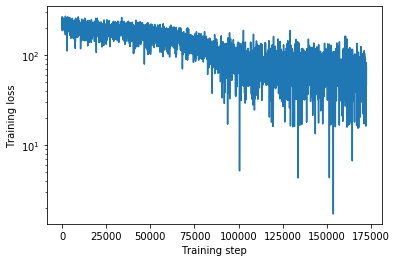

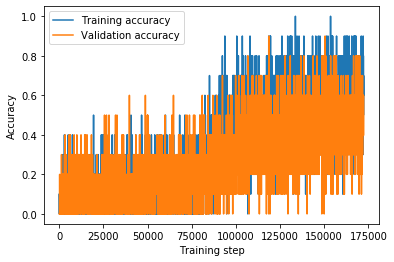

In [20]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did our network do? Is the classification accuracy high? 
    - The classification accuracy is pretty poor -- it ranges between 20% and 70%.
2. How many iterations did it take for the training accuracy to stop increasing?
    - The training accuracy converged after around 100,000 steps.
3. How many iterations did it take for the training loss to stop decreasing?
    - The training accuracy converged after around 150,000 steps.
4. How many iterations did it take for the validation accuracy to stop increasing?
    - The validation accuracy converged after around 100,000 steps.

## Exercise 3 - network width

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built.

In [21]:
# let's set some hyperparameters
batch_size = 10
learning_rate = 0.00001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider hidden layer
num_hidden = 100
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

# create the optimizer
optimizer = optim.SGD([layer_1.weight, layer_1.bias,
                       layer_2.weight, layer_2.bias],
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        hidden_layer = layer_1(train_data_batch)
        output = layer_2(hidden_layer)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_hidden = layer_1(valid_data_batch)
                    valid_output = layer_2(valid_hidden)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np = np.concatenate(prediction_np.reshape(-1,1), axis=0)
                    labels_np = np.concatenate(valid_labels_batch.numpy().reshape(-1,1), axis=0)


                # compute the accuracy over the whole dataset
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 254.344 training accuracy: 0.000 validation accuracy: 0.000 
Step 100 loss: 273.006 training accuracy: 0.000 validation accuracy: 0.000 
Step 150 loss: 265.139 training accuracy: 0.000 validation accuracy: 0.000 
Step 200 loss: 274.221 training accuracy: 0.000 validation accuracy: 0.000 
Step 250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 300 loss: 275.714 training accuracy: 0.000 validation accuracy: 0.000 
Step 350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 400 loss: 267.902 training accuracy: 0.000 validation accuracy: 0.000 
Step 450 loss: 239.642 training accuracy: 0.100 validation accuracy: 0.100 
Step 500 loss: 263.600 training accuracy: 0.000 validation accuracy: 0.000 
Step 550 loss: 246.674 training accuracy: 0.100 validation accuracy: 0.000 
Step 600 loss: 252.269 training accuracy: 0.000 validation accuracy: 0.000 
Step 650 loss: 269.264 training accuracy: 0.000 validation accuracy: 0.100 
Step 700 loss

Step 5400 loss: 227.392 training accuracy: 0.100 validation accuracy: 0.100 
Step 5450 loss: 238.870 training accuracy: 0.100 validation accuracy: 0.100 
Step 5500 loss: 268.632 training accuracy: 0.000 validation accuracy: 0.200 
Step 5550 loss: 270.105 training accuracy: 0.000 validation accuracy: 0.100 
Step 5600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5650 loss: 258.916 training accuracy: 0.000 validation accuracy: 0.000 
Step 5700 loss: 270.269 training accuracy: 0.000 validation accuracy: 0.100 
Step 5750 loss: 248.615 training accuracy: 0.100 validation accuracy: 0.100 
Step 5800 loss: 267.021 training accuracy: 0.000 validation accuracy: 0.000 
Step 5850 loss: 264.511 training accuracy: 0.000 validation accuracy: 0.100 
Step 5900 loss: 238.704 training accuracy: 0.000 validation accuracy: 0.200 
Step 5950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 6000 loss: 264.049 training accuracy: 0.000 validation accuracy: 0.100 

Step 10800 loss: 225.009 training accuracy: 0.100 validation accuracy: 0.200 
Step 10850 loss: 265.744 training accuracy: 0.000 validation accuracy: 0.200 
Step 10900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 10950 loss: 236.886 training accuracy: 0.100 validation accuracy: 0.200 
Step 11000 loss: 213.766 training accuracy: 0.200 validation accuracy: 0.100 
Step 11050 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.300 
Step 11100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 11150 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 11200 loss: 234.320 training accuracy: 0.100 validation accuracy: 0.000 
Step 11250 loss: 242.227 training accuracy: 0.000 validation accuracy: 0.000 
Step 11300 loss: 156.563 training accuracy: 0.400 validation accuracy: 0.100 
Step 11350 loss: 250.204 training accuracy: 0.000 validation accuracy: 0.300 
Step 11400 loss: 236.688 training accuracy: 0.100 validation acc

Step 16200 loss: 127.102 training accuracy: 0.500 validation accuracy: 0.200 
Step 16250 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 16300 loss: 188.856 training accuracy: 0.300 validation accuracy: 0.300 
Step 16350 loss: 153.531 training accuracy: 0.400 validation accuracy: 0.300 
Step 16400 loss: 180.897 training accuracy: 0.300 validation accuracy: 0.200 
Step 16450 loss: 126.223 training accuracy: 0.500 validation accuracy: 0.300 
Step 16500 loss: 165.785 training accuracy: 0.400 validation accuracy: 0.200 
Step 16550 loss: 98.797 training accuracy: 0.600 validation accuracy: 0.300 
Step 16600 loss: 85.596 training accuracy: 0.600 validation accuracy: 0.100 
Step 16650 loss: 165.407 training accuracy: 0.400 validation accuracy: 0.100 
Step 16700 loss: 160.200 training accuracy: 0.400 validation accuracy: 0.200 
Step 16750 loss: 137.972 training accuracy: 0.500 validation accuracy: 0.300 
Step 16800 loss: 183.059 training accuracy: 0.300 validation accur

Step 21500 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 21550 loss: 116.889 training accuracy: 0.500 validation accuracy: 0.100 
Step 21600 loss: 130.170 training accuracy: 0.500 validation accuracy: 0.500 
Step 21650 loss: 136.577 training accuracy: 0.500 validation accuracy: 0.200 
Step 21700 loss: 224.884 training accuracy: 0.100 validation accuracy: 0.600 
Step 21750 loss: 100.417 training accuracy: 0.600 validation accuracy: 0.300 
Step 21800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 21850 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 21900 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 21950 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 22000 loss: 101.362 training accuracy: 0.600 validation accuracy: 0.200 
Step 22050 loss: 165.769 training accuracy: 0.400 validation accuracy: 0.100 
Step 22100 loss: 110.517 training accuracy: 0.600 validation accu

Step 26800 loss: 165.783 training accuracy: 0.400 validation accuracy: 0.000 
Step 26850 loss: 126.994 training accuracy: 0.500 validation accuracy: 0.700 
Step 26900 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 26950 loss: 210.677 training accuracy: 0.200 validation accuracy: 0.300 
Step 27000 loss: 127.449 training accuracy: 0.500 validation accuracy: 0.200 
Step 27050 loss: 166.114 training accuracy: 0.400 validation accuracy: 0.100 
Step 27100 loss: 181.355 training accuracy: 0.300 validation accuracy: 0.300 
Step 27150 loss: 203.770 training accuracy: 0.200 validation accuracy: 0.200 
Step 27200 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.200 
Step 27250 loss: 165.785 training accuracy: 0.400 validation accuracy: 0.400 
Step 27300 loss: 178.128 training accuracy: 0.300 validation accuracy: 0.100 
Step 27350 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.600 
Step 27400 loss: 193.261 training accuracy: 0.300 validation accu

Step 32150 loss: 121.768 training accuracy: 0.500 validation accuracy: 0.200 
Step 32200 loss: 210.862 training accuracy: 0.200 validation accuracy: 0.200 
Step 32250 loss: 60.424 training accuracy: 0.700 validation accuracy: 0.200 
Step 32300 loss: 44.773 training accuracy: 0.800 validation accuracy: 0.400 
Step 32350 loss: 169.909 training accuracy: 0.300 validation accuracy: 0.100 
Step 32400 loss: 153.394 training accuracy: 0.400 validation accuracy: 0.400 
Step 32450 loss: 153.620 training accuracy: 0.400 validation accuracy: 0.200 
Step 32500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 32550 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 32600 loss: 98.120 training accuracy: 0.600 validation accuracy: 0.500 
Step 32650 loss: 99.985 training accuracy: 0.600 validation accuracy: 0.300 
Step 32700 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 32750 loss: 98.166 training accuracy: 0.600 validation accuracy:

Step 37450 loss: 150.429 training accuracy: 0.400 validation accuracy: 0.300 
Step 37500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 37550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 37600 loss: 125.786 training accuracy: 0.500 validation accuracy: 0.200 
Step 37650 loss: 158.329 training accuracy: 0.300 validation accuracy: 0.200 
Step 37700 loss: 165.893 training accuracy: 0.400 validation accuracy: 0.300 
Step 37750 loss: 141.309 training accuracy: 0.400 validation accuracy: 0.200 
Step 37800 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 37850 loss: 221.013 training accuracy: 0.200 validation accuracy: 0.200 
Step 37900 loss: 98.740 training accuracy: 0.600 validation accuracy: 0.300 
Step 37950 loss: 138.139 training accuracy: 0.500 validation accuracy: 0.400 
Step 38000 loss: 125.848 training accuracy: 0.500 validation accuracy: 0.200 
Step 38050 loss: 126.374 training accuracy: 0.500 validation accu

Step 42800 loss: 75.489 training accuracy: 0.700 validation accuracy: 0.200 
Step 42850 loss: 185.114 training accuracy: 0.300 validation accuracy: 0.400 
Step 42900 loss: 98.670 training accuracy: 0.600 validation accuracy: 0.300 
Step 42950 loss: 153.376 training accuracy: 0.400 validation accuracy: 0.400 
Step 43000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 43050 loss: 181.360 training accuracy: 0.300 validation accuracy: 0.200 
Step 43100 loss: 107.254 training accuracy: 0.500 validation accuracy: 0.300 
Step 43150 loss: 99.151 training accuracy: 0.600 validation accuracy: 0.300 
Step 43200 loss: 78.063 training accuracy: 0.600 validation accuracy: 0.400 
Step 43250 loss: 177.197 training accuracy: 0.300 validation accuracy: 0.200 
Step 43300 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 43350 loss: 153.902 training accuracy: 0.400 validation accuracy: 0.100 
Step 43400 loss: 181.632 training accuracy: 0.300 validation accurac

Step 48100 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 48150 loss: 135.991 training accuracy: 0.500 validation accuracy: 0.500 
Step 48200 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 48250 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 48300 loss: 170.222 training accuracy: 0.300 validation accuracy: 0.400 
Step 48350 loss: 236.278 training accuracy: 0.100 validation accuracy: 0.700 
Step 48400 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 48450 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 48500 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 48550 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 48600 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 48650 loss: 45.011 training accuracy: 0.800 validation accuracy: 0.600 
Step 48700 loss: 138.155 training accuracy: 0.500 validation accura

Step 53500 loss: 153.401 training accuracy: 0.400 validation accuracy: 0.300 
Step 53550 loss: 99.686 training accuracy: 0.600 validation accuracy: 0.500 
Step 53600 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 53650 loss: 209.766 training accuracy: 0.200 validation accuracy: 0.200 
Step 53700 loss: 181.653 training accuracy: 0.300 validation accuracy: 0.500 
Step 53750 loss: 153.554 training accuracy: 0.400 validation accuracy: 0.200 
Step 53800 loss: 43.408 training accuracy: 0.800 validation accuracy: 0.300 
Step 53850 loss: 168.958 training accuracy: 0.300 validation accuracy: 0.300 
Step 53900 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 53950 loss: 129.712 training accuracy: 0.400 validation accuracy: 0.500 
Step 54000 loss: 125.736 training accuracy: 0.500 validation accuracy: 0.200 
Step 54050 loss: 110.523 training accuracy: 0.600 validation accuracy: 0.300 
Step 54100 loss: 55.262 training accuracy: 0.800 validation accurac

Step 58850 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 58900 loss: 125.744 training accuracy: 0.500 validation accuracy: 0.300 
Step 58950 loss: 125.853 training accuracy: 0.500 validation accuracy: 0.400 
Step 59000 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 59050 loss: 98.180 training accuracy: 0.600 validation accuracy: 0.400 
Step 59100 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 59150 loss: 86.609 training accuracy: 0.600 validation accuracy: 0.100 
Step 59200 loss: 141.338 training accuracy: 0.400 validation accuracy: 0.400 
Step 59250 loss: 70.633 training accuracy: 0.700 validation accuracy: 0.500 
Step 59300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 59350 loss: 168.565 training accuracy: 0.300 validation accuracy: 0.200 
Step 59400 loss: 159.389 training accuracy: 0.300 validation accuracy: 0.600 
Step 59450 loss: 55.262 training accuracy: 0.800 validation accuracy:

Step 64200 loss: 125.589 training accuracy: 0.500 validation accuracy: 0.200 
Step 64250 loss: 142.536 training accuracy: 0.400 validation accuracy: 0.300 
Step 64300 loss: 101.055 training accuracy: 0.600 validation accuracy: 0.500 
Step 64350 loss: 168.673 training accuracy: 0.300 validation accuracy: 0.200 
Step 64400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 64450 loss: 154.956 training accuracy: 0.400 validation accuracy: 0.500 
Step 64500 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 64550 loss: 113.509 training accuracy: 0.500 validation accuracy: 0.100 
Step 64600 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 64650 loss: 153.397 training accuracy: 0.400 validation accuracy: 0.200 
Step 64700 loss: 134.883 training accuracy: 0.400 validation accuracy: 0.200 
Step 64750 loss: 70.469 training accuracy: 0.700 validation accuracy: 0.100 
Step 64800 loss: 182.205 training accuracy: 0.300 validation accu

Step 69600 loss: 183.832 training accuracy: 0.200 validation accuracy: 0.300 
Step 69650 loss: 165.759 training accuracy: 0.400 validation accuracy: 0.200 
Step 69700 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 69750 loss: 113.337 training accuracy: 0.500 validation accuracy: 0.300 
Step 69800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 69850 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 69900 loss: 113.413 training accuracy: 0.500 validation accuracy: 0.600 
Step 69950 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 70000 loss: 138.145 training accuracy: 0.500 validation accuracy: 0.200 
Step 70050 loss: 125.834 training accuracy: 0.500 validation accuracy: 0.500 
Step 70100 loss: 58.200 training accuracy: 0.700 validation accuracy: 0.200 
Step 70150 loss: 98.103 training accuracy: 0.600 validation accuracy: 0.200 
Step 70200 loss: 58.311 training accuracy: 0.700 validation accura

Step 74900 loss: 168.573 training accuracy: 0.300 validation accuracy: 0.400 
Step 74950 loss: 125.730 training accuracy: 0.500 validation accuracy: 0.400 
Step 75000 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 75050 loss: 181.766 training accuracy: 0.300 validation accuracy: 0.300 
Step 75100 loss: 133.784 training accuracy: 0.500 validation accuracy: 0.200 
Step 75150 loss: 85.819 training accuracy: 0.600 validation accuracy: 0.100 
Step 75200 loss: 98.585 training accuracy: 0.600 validation accuracy: 0.500 
Step 75250 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.800 
Step 75300 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 75350 loss: 141.049 training accuracy: 0.400 validation accuracy: 0.300 
Step 75400 loss: 125.726 training accuracy: 0.500 validation accuracy: 0.500 
Step 75450 loss: 140.933 training accuracy: 0.400 validation accuracy: 0.400 
Step 75500 loss: 181.105 training accuracy: 0.300 validation accurac

Step 80300 loss: 153.378 training accuracy: 0.400 validation accuracy: 0.100 
Step 80350 loss: 221.046 training accuracy: 0.200 validation accuracy: 0.400 
Step 80400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 80450 loss: 70.510 training accuracy: 0.700 validation accuracy: 0.400 
Step 80500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 80550 loss: 72.021 training accuracy: 0.700 validation accuracy: 0.500 
Step 80600 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 80650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 80700 loss: 125.714 training accuracy: 0.500 validation accuracy: 0.400 
Step 80750 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 80800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 80850 loss: 208.738 training accuracy: 0.200 validation accuracy: 0.100 
Step 80900 loss: 180.998 training accuracy: 0.300 validation accura

Step 85700 loss: -0.000 training accuracy: 1.000 validation accuracy: 0.200 
Step 85750 loss: 153.407 training accuracy: 0.400 validation accuracy: 0.300 
Step 85800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 85850 loss: 98.768 training accuracy: 0.600 validation accuracy: 0.300 
Step 85900 loss: 153.418 training accuracy: 0.400 validation accuracy: 0.400 
Step 85950 loss: 182.030 training accuracy: 0.300 validation accuracy: 0.300 
Step 86000 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 86050 loss: 27.631 training accuracy: 0.900 validation accuracy: 0.500 
Step 86100 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 86150 loss: 153.382 training accuracy: 0.400 validation accuracy: 0.300 
Step 86200 loss: 171.623 training accuracy: 0.300 validation accuracy: 0.200 
Step 86250 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 86300 loss: 153.646 training accuracy: 0.400 validation accurac

Step 91100 loss: 126.751 training accuracy: 0.500 validation accuracy: 0.400 
Step 91150 loss: 181.077 training accuracy: 0.300 validation accuracy: 0.200 
Step 91200 loss: 128.522 training accuracy: 0.400 validation accuracy: 0.100 
Step 91250 loss: 168.726 training accuracy: 0.300 validation accuracy: 0.600 
Step 91300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 91350 loss: 86.314 training accuracy: 0.600 validation accuracy: 0.500 
Step 91400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 91450 loss: 128.787 training accuracy: 0.400 validation accuracy: 0.300 
Step 91500 loss: 153.522 training accuracy: 0.400 validation accuracy: 0.200 
Step 91550 loss: 141.145 training accuracy: 0.400 validation accuracy: 0.200 
Step 91600 loss: 148.788 training accuracy: 0.400 validation accuracy: 0.300 
Step 91650 loss: 125.729 training accuracy: 0.500 validation accuracy: 0.300 
Step 91700 loss: 134.826 training accuracy: 0.500 validation accur

Step 96500 loss: 125.737 training accuracy: 0.500 validation accuracy: 0.200 
Step 96550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.100 
Step 96600 loss: 98.133 training accuracy: 0.600 validation accuracy: 0.300 
Step 96650 loss: 153.389 training accuracy: 0.400 validation accuracy: 0.300 
Step 96700 loss: 236.398 training accuracy: 0.100 validation accuracy: 0.500 
Step 96750 loss: 98.272 training accuracy: 0.600 validation accuracy: 0.200 
Step 96800 loss: 70.464 training accuracy: 0.700 validation accuracy: 0.300 
Step 96850 loss: 138.061 training accuracy: 0.500 validation accuracy: 0.400 
Step 96900 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 96950 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 97000 loss: 156.308 training accuracy: 0.400 validation accuracy: 0.300 
Step 97050 loss: 43.171 training accuracy: 0.800 validation accuracy: 0.100 
Step 97100 loss: 125.906 training accuracy: 0.500 validation accurac

Step 101750 loss: 110.520 training accuracy: 0.600 validation accuracy: 0.500 
Step 101800 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 101850 loss: 113.714 training accuracy: 0.500 validation accuracy: 0.300 
Step 101900 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 101950 loss: 153.374 training accuracy: 0.400 validation accuracy: 0.400 
Step 102000 loss: 153.402 training accuracy: 0.400 validation accuracy: 0.300 
Step 102050 loss: 156.271 training accuracy: 0.300 validation accuracy: 0.200 
Step 102100 loss: 208.595 training accuracy: 0.200 validation accuracy: 0.300 
Step 102150 loss: 125.729 training accuracy: 0.500 validation accuracy: 0.300 
Step 102200 loss: 126.121 training accuracy: 0.500 validation accuracy: 0.300 
Step 102250 loss: 98.119 training accuracy: 0.600 validation accuracy: 0.300 
Step 102300 loss: 106.042 training accuracy: 0.600 validation accuracy: 0.400 
Step 102350 loss: 153.426 training accuracy: 0.400 vali

Step 107000 loss: 85.810 training accuracy: 0.600 validation accuracy: 0.200 
Step 107050 loss: 125.736 training accuracy: 0.500 validation accuracy: 0.400 
Step 107100 loss: 113.403 training accuracy: 0.500 validation accuracy: 0.400 
Step 107150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.100 
Step 107200 loss: 98.192 training accuracy: 0.600 validation accuracy: 0.300 
Step 107250 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 107300 loss: 113.323 training accuracy: 0.500 validation accuracy: 0.300 
Step 107350 loss: 98.591 training accuracy: 0.600 validation accuracy: 0.300 
Step 107400 loss: 125.821 training accuracy: 0.500 validation accuracy: 0.300 
Step 107450 loss: 98.095 training accuracy: 0.600 validation accuracy: 0.700 
Step 107500 loss: 153.355 training accuracy: 0.400 validation accuracy: 0.300 
Step 107550 loss: 70.553 training accuracy: 0.700 validation accuracy: 0.500 
Step 107600 loss: 98.110 training accuracy: 0.600 validat

Step 112350 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 112400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 112450 loss: 113.294 training accuracy: 0.500 validation accuracy: 0.000 
Step 112500 loss: 168.735 training accuracy: 0.300 validation accuracy: 0.200 
Step 112550 loss: 98.118 training accuracy: 0.600 validation accuracy: 0.300 
Step 112600 loss: 116.163 training accuracy: 0.400 validation accuracy: 0.400 
Step 112650 loss: 153.359 training accuracy: 0.400 validation accuracy: 0.300 
Step 112700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 112750 loss: 125.846 training accuracy: 0.500 validation accuracy: 0.300 
Step 112800 loss: 138.143 training accuracy: 0.500 validation accuracy: 0.300 
Step 112850 loss: 141.068 training accuracy: 0.400 validation accuracy: 0.400 
Step 112900 loss: 70.459 training accuracy: 0.700 validation accuracy: 0.300 
Step 112950 loss: 82.893 training accuracy: 0.700 valid

Step 117700 loss: 141.019 training accuracy: 0.400 validation accuracy: 0.100 
Step 117750 loss: 181.118 training accuracy: 0.300 validation accuracy: 0.500 
Step 117800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 117850 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 117900 loss: 153.357 training accuracy: 0.400 validation accuracy: 0.400 
Step 117950 loss: 153.379 training accuracy: 0.400 validation accuracy: 0.300 
Step 118000 loss: 153.357 training accuracy: 0.400 validation accuracy: 0.300 
Step 118050 loss: 153.357 training accuracy: 0.400 validation accuracy: 0.200 
Step 118100 loss: 135.226 training accuracy: 0.500 validation accuracy: 0.300 
Step 118150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 118200 loss: 180.993 training accuracy: 0.300 validation accuracy: 0.300 
Step 118250 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 118300 loss: 113.476 training accuracy: 0.500 va

Step 122950 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 123000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 123050 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 123100 loss: 153.330 training accuracy: 0.400 validation accuracy: 0.300 
Step 123150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 123200 loss: 236.300 training accuracy: 0.100 validation accuracy: 0.200 
Step 123250 loss: 181.014 training accuracy: 0.300 validation accuracy: 0.200 
Step 123300 loss: 70.641 training accuracy: 0.700 validation accuracy: 0.300 
Step 123350 loss: 141.016 training accuracy: 0.400 validation accuracy: 0.500 
Step 123400 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.000 
Step 123450 loss: 193.416 training accuracy: 0.300 validation accuracy: 0.400 
Step 123500 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.500 
Step 123550 loss: 140.989 training accuracy: 0.400 val

Step 128150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 128200 loss: 181.199 training accuracy: 0.300 validation accuracy: 0.500 
Step 128250 loss: 98.103 training accuracy: 0.600 validation accuracy: 0.200 
Step 128300 loss: 131.405 training accuracy: 0.300 validation accuracy: 0.300 
Step 128350 loss: 153.363 training accuracy: 0.400 validation accuracy: 0.500 
Step 128400 loss: 143.697 training accuracy: 0.300 validation accuracy: 0.300 
Step 128450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 128500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 128550 loss: 141.082 training accuracy: 0.400 validation accuracy: 0.200 
Step 128600 loss: 113.639 training accuracy: 0.500 validation accuracy: 0.500 
Step 128650 loss: 98.140 training accuracy: 0.600 validation accuracy: 0.400 
Step 128700 loss: 98.128 training accuracy: 0.600 validation accuracy: 0.800 
Step 128750 loss: 140.931 training accuracy: 0.400 valid

Step 133350 loss: 42.854 training accuracy: 0.800 validation accuracy: 0.400 
Step 133400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 133450 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.300 
Step 133500 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 133550 loss: 128.466 training accuracy: 0.400 validation accuracy: 0.300 
Step 133600 loss: 100.929 training accuracy: 0.500 validation accuracy: 0.000 
Step 133650 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 133700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 133750 loss: 141.413 training accuracy: 0.400 validation accuracy: 0.300 
Step 133800 loss: 125.739 training accuracy: 0.500 validation accuracy: 0.400 
Step 133850 loss: 85.748 training accuracy: 0.600 validation accuracy: 0.500 
Step 133900 loss: 153.573 training accuracy: 0.400 validation accuracy: 0.200 
Step 133950 loss: 168.758 training accuracy: 0.300 vali

Step 138600 loss: 141.095 training accuracy: 0.400 validation accuracy: 0.300 
Step 138650 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.700 
Step 138700 loss: 113.307 training accuracy: 0.500 validation accuracy: 0.300 
Step 138750 loss: 141.178 training accuracy: 0.400 validation accuracy: 0.400 
Step 138800 loss: 125.727 training accuracy: 0.500 validation accuracy: 0.300 
Step 138850 loss: 153.357 training accuracy: 0.400 validation accuracy: 0.400 
Step 138900 loss: 110.505 training accuracy: 0.600 validation accuracy: 0.300 
Step 138950 loss: 153.357 training accuracy: 0.400 validation accuracy: 0.500 
Step 139000 loss: 196.208 training accuracy: 0.200 validation accuracy: 0.400 
Step 139050 loss: 156.223 training accuracy: 0.300 validation accuracy: 0.300 
Step 139100 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 139150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 139200 loss: 153.344 training accuracy: 0.400 v

Step 143850 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 143900 loss: 125.723 training accuracy: 0.500 validation accuracy: 0.400 
Step 143950 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 144000 loss: 100.905 training accuracy: 0.500 validation accuracy: 0.300 
Step 144050 loss: 98.100 training accuracy: 0.600 validation accuracy: 0.800 
Step 144100 loss: 85.874 training accuracy: 0.600 validation accuracy: 0.400 
Step 144150 loss: 153.363 training accuracy: 0.400 validation accuracy: 0.400 
Step 144200 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 144250 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.400 
Step 144300 loss: 141.281 training accuracy: 0.400 validation accuracy: 0.000 
Step 144350 loss: 125.718 training accuracy: 0.500 validation accuracy: 0.500 
Step 144400 loss: 156.596 training accuracy: 0.300 validation accuracy: 0.200 
Step 144450 loss: 181.075 training accuracy: 0.300 valid

Step 149100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 149150 loss: 208.622 training accuracy: 0.200 validation accuracy: 0.300 
Step 149200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 149250 loss: 125.740 training accuracy: 0.500 validation accuracy: 0.200 
Step 149300 loss: 126.251 training accuracy: 0.500 validation accuracy: 0.500 
Step 149350 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 149400 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 149450 loss: 113.354 training accuracy: 0.500 validation accuracy: 0.500 
Step 149500 loss: 125.812 training accuracy: 0.500 validation accuracy: 0.300 
Step 149550 loss: 168.611 training accuracy: 0.300 validation accuracy: 0.200 
Step 149600 loss: 125.746 training accuracy: 0.500 validation accuracy: 0.300 
Step 149650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 149700 loss: 248.679 training accuracy: 0.100 v

Step 154350 loss: 236.333 training accuracy: 0.100 validation accuracy: 0.100 
Step 154400 loss: 153.410 training accuracy: 0.400 validation accuracy: 0.500 
Step 154450 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 154500 loss: 141.104 training accuracy: 0.400 validation accuracy: 0.200 
Step 154550 loss: 125.728 training accuracy: 0.500 validation accuracy: 0.200 
Step 154600 loss: 113.470 training accuracy: 0.500 validation accuracy: 0.200 
Step 154650 loss: 236.296 training accuracy: 0.100 validation accuracy: 0.300 
Step 154700 loss: 98.165 training accuracy: 0.600 validation accuracy: 0.200 
Step 154750 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.700 
Step 154800 loss: 153.470 training accuracy: 0.400 validation accuracy: 0.200 
Step 154850 loss: 113.578 training accuracy: 0.500 validation accuracy: 0.300 
Step 154900 loss: 42.872 training accuracy: 0.800 validation accuracy: 0.300 
Step 154950 loss: 125.908 training accuracy: 0.500 vali

Step 159600 loss: 110.533 training accuracy: 0.600 validation accuracy: 0.200 
Step 159650 loss: 125.904 training accuracy: 0.500 validation accuracy: 0.600 
Step 159700 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.100 
Step 159750 loss: 208.619 training accuracy: 0.200 validation accuracy: 0.400 
Step 159800 loss: 181.773 training accuracy: 0.300 validation accuracy: 0.700 
Step 159850 loss: 208.666 training accuracy: 0.200 validation accuracy: 0.500 
Step 159900 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 159950 loss: 101.144 training accuracy: 0.500 validation accuracy: 0.400 
Step 160000 loss: 153.358 training accuracy: 0.400 validation accuracy: 0.600 
Step 160050 loss: 98.136 training accuracy: 0.600 validation accuracy: 0.400 
Step 160100 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 160150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 160200 loss: 153.441 training accuracy: 0.400 va

Step 164900 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 164950 loss: 70.464 training accuracy: 0.700 validation accuracy: 0.300 
Step 165000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 165050 loss: 153.470 training accuracy: 0.400 validation accuracy: 0.400 
Step 165100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 165150 loss: 70.536 training accuracy: 0.700 validation accuracy: 0.400 
Step 165200 loss: 125.825 training accuracy: 0.500 validation accuracy: 0.300 
Step 165250 loss: 145.809 training accuracy: 0.400 validation accuracy: 0.000 
Step 165300 loss: 236.253 training accuracy: 0.100 validation accuracy: 0.300 
Step 165350 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 165400 loss: 165.785 training accuracy: 0.400 validation accuracy: 0.000 
Step 165450 loss: 113.606 training accuracy: 0.500 validation accuracy: 0.300 
Step 165500 loss: 55.262 training accuracy: 0.800 valid

Step 170150 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 170200 loss: 128.541 training accuracy: 0.400 validation accuracy: 0.100 
Step 170250 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 170300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 170350 loss: 197.181 training accuracy: 0.200 validation accuracy: 0.600 
Step 170400 loss: 153.364 training accuracy: 0.400 validation accuracy: 0.400 
Step 170450 loss: 153.411 training accuracy: 0.400 validation accuracy: 0.600 
Step 170500 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 170550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 170600 loss: 153.357 training accuracy: 0.400 validation accuracy: 0.400 
Step 170650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.100 
Step 170700 loss: 208.651 training accuracy: 0.200 validation accuracy: 0.300 
Step 170750 loss: 153.368 training accuracy: 0.400 v

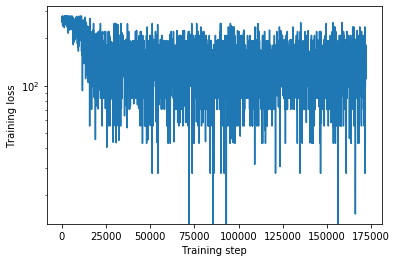

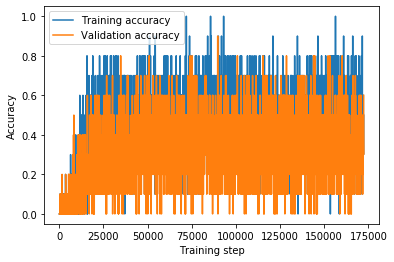

In [22]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - network depth

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built.

In [23]:
# let's set some hyperparameters
batch_size = 10
learning_rate = 0.00001
n_epochs = 100
print_every = 50
num_hidden = 100

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
# ========
# Create an additional hidden layer
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
# ========
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the optimizer
optimizer = optim.SGD(
    # ========
    # Add all of the network weights for the three layers
    [layer_1.weight, layer_1.bias,
     layer_2.weight, layer_2.bias,
     layer_3.weight, layer_3.bias],
    # ========
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        hidden_layer1 = layer_1(train_data_batch)
        # ========
        # Apply your additional hidden layer
        hidden_layer2 = layer_2(hidden_layer1)
        # ========
        output = layer_3(hidden_layer2)
        
        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_hidden1 = layer_1(valid_data_batch)
                    # ========
                    # Apply your additional hidden layer
                    valid_hidden2 = layer_2(valid_hidden1)
                    # ========
                    valid_output = layer_3(valid_hidden2)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np = np.concatenate(prediction_np.reshape(-1,1), axis=0)
                    labels_np = np.concatenate(valid_labels_batch.numpy().reshape(-1,1), axis=0)


                # compute the accuracy over the whole dataset
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 150 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 200 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 250 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.100 
Step 300 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.000 
Step 350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 450 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.100 
Step 500 loss: 276.232 training accuracy: 0.000 validation accuracy: 0.100 
Step 550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.300 
Step 600 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.100 
Step 650 loss: 243.108 training accuracy: 0.100 validation accuracy: 0.100 
Step 700 loss

Step 5450 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.100 
Step 5500 loss: 138.136 training accuracy: 0.500 validation accuracy: 0.300 
Step 5550 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 5600 loss: 192.644 training accuracy: 0.300 validation accuracy: 0.100 
Step 5650 loss: 191.158 training accuracy: 0.300 validation accuracy: 0.400 
Step 5700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 5750 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 5800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 5850 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 5900 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 5950 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 6000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 6050 loss: 165.779 training accuracy: 0.400 validation accuracy: 0.500 

Step 10850 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 10900 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.600 
Step 10950 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.100 
Step 11000 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 11050 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.500 
Step 11100 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 11150 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 11200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 11250 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.000 
Step 11300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 11350 loss: 185.379 training accuracy: 0.300 validation accuracy: 0.400 
Step 11400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 11450 loss: 110.524 training accuracy: 0.600 validation accura

Step 16150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 16200 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 16250 loss: 133.505 training accuracy: 0.500 validation accuracy: 0.200 
Step 16300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 16350 loss: 107.131 training accuracy: 0.600 validation accuracy: 0.400 
Step 16400 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 16450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 16500 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 16550 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 16600 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 16650 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 16700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 16750 loss: 193.417 training accuracy: 0.300 validation accur

Step 21450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 21500 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 21550 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 21600 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 21650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 21700 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.100 
Step 21750 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 21800 loss: 72.071 training accuracy: 0.700 validation accuracy: 0.500 
Step 21850 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 21900 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 21950 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.100 
Step 22000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 22050 loss: 110.524 training accuracy: 0.600 validation accura

Step 26750 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 26800 loss: 213.388 training accuracy: 0.200 validation accuracy: 0.300 
Step 26850 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 26900 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 26950 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 27000 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 27050 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 27100 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 27150 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 27200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 27250 loss: 165.783 training accuracy: 0.400 validation accuracy: 0.300 
Step 27300 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 27350 loss: 138.155 training accuracy: 0.500 validation accura

Step 32050 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 32100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.600 
Step 32150 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 32200 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 32250 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 32300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 32350 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 32400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.000 
Step 32450 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 32500 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 32550 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.600 
Step 32600 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 32650 loss: 193.417 training accuracy: 0.300 validation acc

Step 37350 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.600 
Step 37400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 37450 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.700 
Step 37500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 37550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.700 
Step 37600 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 37650 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.000 
Step 37700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 37750 loss: 192.761 training accuracy: 0.300 validation accuracy: 0.200 
Step 37800 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.500 
Step 37850 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 37900 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 37950 loss: 165.786 training accuracy: 0.400 validation accu

Step 42650 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 42700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 42750 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 42800 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 42850 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 42900 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.100 
Step 42950 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 43000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 43050 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 43100 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 43150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 43200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 43250 loss: 138.155 training accuracy: 0.500 validation accura

Step 47950 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.200 
Step 48000 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 48050 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 48100 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 48150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 48200 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 48250 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 48300 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 48350 loss: 137.135 training accuracy: 0.500 validation accuracy: 0.200 
Step 48400 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 48450 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 48500 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 48550 loss: 110.524 training accuracy: 0.600 validation accu

Step 53250 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 53300 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.200 
Step 53350 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 53400 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 53450 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 53500 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 53550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 53600 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 53650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 53700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 53750 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 53800 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 53850 loss: 138.155 training accuracy: 0.500 validation accu

Step 58550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.800 
Step 58600 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 58650 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.300 
Step 58700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 58750 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.100 
Step 58800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 58850 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.300 
Step 58900 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 58950 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.000 
Step 59000 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 59050 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.100 
Step 59100 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.200 
Step 59150 loss: 165.786 training accuracy: 0.400 validation accura

Step 63850 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 63900 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 63950 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.000 
Step 64000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 64050 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 64100 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.800 
Step 64150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 64200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 64250 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 64300 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 64350 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 64400 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 64450 loss: 110.524 training accuracy: 0.600 validation accu

Step 69150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 69200 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 69250 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 69300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 69350 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 69400 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 69450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 69500 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.300 
Step 69550 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.200 
Step 69600 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.100 
Step 69650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 69700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 69750 loss: 193.417 training accuracy: 0.300 validation accurac

Step 74450 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 74500 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 74550 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 74600 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.100 
Step 74650 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.600 
Step 74700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 74750 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 74800 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.200 
Step 74850 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 74900 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 74950 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 75000 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 75050 loss: 161.750 training accuracy: 0.400 validation accur

Step 79750 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.700 
Step 79800 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 79850 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 79900 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 79950 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 80000 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 80050 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 80100 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 80150 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 80200 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.600 
Step 80250 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.700 
Step 80300 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 80350 loss: 193.417 training accuracy: 0.300 validation accur

Step 85050 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 85100 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 85150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 85200 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 85250 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 85300 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 85350 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 85400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 85450 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 85500 loss: 27.631 training accuracy: 0.900 validation accuracy: 0.600 
Step 85550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 85600 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 85650 loss: 138.155 training accuracy: 0.500 validation accurac

Step 90350 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.200 
Step 90400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 90450 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 90500 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 90550 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 90600 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.600 
Step 90650 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 90700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 90750 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 90800 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 90850 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 90900 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 90950 loss: 82.893 training accuracy: 0.700 validation accuracy

Step 95650 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 95700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 95750 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 95800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 95850 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 95900 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 95950 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 96000 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 96050 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.200 
Step 96100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 96150 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.600 
Step 96200 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 96250 loss: 221.048 training accuracy: 0.200 validation acc

Step 100950 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 101000 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 101050 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 101100 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 101150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 101200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 101250 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 101300 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 101350 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 101400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 101450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 101500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 101550 loss: 27.631 training accuracy: 0.900 val

Step 106150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 106200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 106250 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 106300 loss: 110.523 training accuracy: 0.600 validation accuracy: 0.400 
Step 106350 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 106400 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.500 
Step 106450 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 106500 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.800 
Step 106550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 106600 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 106650 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 106700 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 106750 loss: 110.524 training accuracy: 0.600 vali

Step 111350 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 111400 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 111450 loss: 138.153 training accuracy: 0.500 validation accuracy: 0.500 
Step 111500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 111550 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 111600 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 111650 loss: 129.231 training accuracy: 0.500 validation accuracy: 0.300 
Step 111700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 111750 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 111800 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 111850 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 111900 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 111950 loss: 82.893 training accuracy: 0.700 val

Step 116650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 116700 loss: 138.034 training accuracy: 0.500 validation accuracy: 0.300 
Step 116750 loss: 165.738 training accuracy: 0.400 validation accuracy: 0.200 
Step 116800 loss: 133.787 training accuracy: 0.500 validation accuracy: 0.600 
Step 116850 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 116900 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 116950 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 117000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 117050 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.100 
Step 117100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 117150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.200 
Step 117200 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 117250 loss: 138.155 training accuracy: 0.500 valid

Step 121850 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 121900 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 121950 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 122000 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 122050 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 122100 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 122150 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 122200 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 122250 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 122300 loss: -0.000 training accuracy: 1.000 validation accuracy: 0.200 
Step 122350 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 122400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.600 
Step 122450 loss: 248.679 training accuracy: 0.100 vali

Step 127050 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.200 
Step 127100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 127150 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.300 
Step 127200 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 127250 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.100 
Step 127300 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 127350 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.200 
Step 127400 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 127450 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.300 
Step 127500 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.500 
Step 127550 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 127600 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.600 
Step 127650 loss: 82.893 training accuracy: 0.700 valida

Step 132250 loss: 193.410 training accuracy: 0.300 validation accuracy: 0.200 
Step 132300 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.200 
Step 132350 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 132400 loss: 106.972 training accuracy: 0.600 validation accuracy: 0.300 
Step 132450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 132500 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.300 
Step 132550 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.300 
Step 132600 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 132650 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 132700 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.300 
Step 132750 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 132800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 132850 loss: 55.262 training accuracy: 0.800 valid

Step 137450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 137500 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.600 
Step 137550 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 137600 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 137650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 137700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 137750 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.700 
Step 137800 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 137850 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 137900 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 137950 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 138000 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.200 
Step 138050 loss: 110.524 training accuracy: 0.600 val

Step 142750 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 142800 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.500 
Step 142850 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.600 
Step 142900 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.500 
Step 142950 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 143000 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 143050 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.700 
Step 143100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 143150 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 143200 loss: 27.631 training accuracy: 0.900 validation accuracy: 0.500 
Step 143250 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.600 
Step 143300 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 143350 loss: 110.524 training accuracy: 0.600 validat

Step 148050 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.600 
Step 148100 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.600 
Step 148150 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 148200 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 148250 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.700 
Step 148300 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 148350 loss: -0.000 training accuracy: 1.000 validation accuracy: 0.300 
Step 148400 loss: 78.333 training accuracy: 0.700 validation accuracy: 0.400 
Step 148450 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 148500 loss: 165.783 training accuracy: 0.400 validation accuracy: 0.400 
Step 148550 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 148600 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 148650 loss: 110.524 training accuracy: 0.600 valid

Step 153350 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 153400 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 153450 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 153500 loss: 241.756 training accuracy: 0.100 validation accuracy: 0.600 
Step 153550 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.700 
Step 153600 loss: 159.058 training accuracy: 0.400 validation accuracy: 0.300 
Step 153650 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 153700 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.500 
Step 153750 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 153800 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.200 
Step 153850 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 153900 loss: 135.788 training accuracy: 0.500 validation accuracy: 0.700 
Step 153950 loss: 220.538 training accuracy: 0.200 val

Step 158650 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 158700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 158750 loss: 132.620 training accuracy: 0.500 validation accuracy: 0.500 
Step 158800 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.500 
Step 158850 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.500 
Step 158900 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.400 
Step 158950 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.500 
Step 159000 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 159050 loss: 193.402 training accuracy: 0.300 validation accuracy: 0.400 
Step 159100 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.200 
Step 159150 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.500 
Step 159200 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 159250 loss: 165.786 training accuracy: 0.400 va

Step 163950 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 164000 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 164050 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.100 
Step 164100 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.400 
Step 164150 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.200 
Step 164200 loss: 138.154 training accuracy: 0.500 validation accuracy: 0.600 
Step 164250 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.700 
Step 164300 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.400 
Step 164350 loss: 27.631 training accuracy: 0.900 validation accuracy: 0.200 
Step 164400 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.600 
Step 164450 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.100 
Step 164500 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.600 
Step 164550 loss: 110.524 training accuracy: 0.600 validati

Step 169250 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 169300 loss: 193.417 training accuracy: 0.300 validation accuracy: 0.400 
Step 169350 loss: 110.524 training accuracy: 0.600 validation accuracy: 0.300 
Step 169400 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.600 
Step 169450 loss: 153.367 training accuracy: 0.400 validation accuracy: 0.500 
Step 169500 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.400 
Step 169550 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.500 
Step 169600 loss: 165.786 training accuracy: 0.400 validation accuracy: 0.600 
Step 169650 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.600 
Step 169700 loss: 138.155 training accuracy: 0.500 validation accuracy: 0.300 
Step 169750 loss: 55.262 training accuracy: 0.800 validation accuracy: 0.300 
Step 169800 loss: 82.893 training accuracy: 0.700 validation accuracy: 0.400 
Step 169850 loss: 138.155 training accuracy: 0.500 vali

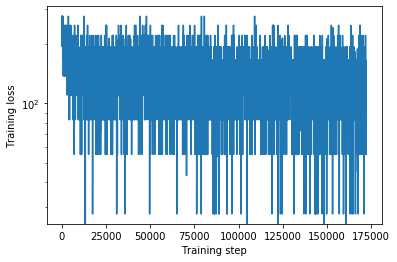

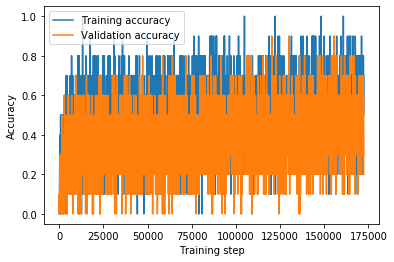

In [24]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 5 - more network depth

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [25]:
# ======
# Create a five-layer network based on the code in the exercise above
# let's set some hyperparameters
batch_size = 10
learning_rate = 0.00001
n_epochs = 100
print_every = 50
num_hidden = 100

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())

# Create additional hidden layers
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_3 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_4 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_5 = layer(num_hidden, num_hidden, activation=nn.ReLU())

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax())

# create the optimizer
optimizer = optim.SGD(
    # Add all of the network weights for the three layers
    [layer_1.weight, layer_1.bias,
     layer_2.weight, layer_2.bias,
     layer_3.weight, layer_3.bias,
     layer_4.weight, layer_4.bias,
     layer_5.weight, layer_5.bias,
     layer_6.weight, layer_6.bias],
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        hidden_layer1 = layer_1(train_data_batch)
        # Apply your additional hidden layers
        hidden_layer2 = layer_2(hidden_layer1)
        hidden_layer3 = layer_3(hidden_layer2)
        hidden_layer4 = layer_4(hidden_layer3)
        hidden_layer5 = layer_5(hidden_layer4)
        output = layer_6(hidden_layer5)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_hidden1 = layer_1(valid_data_batch)
                    # Apply your additional hidden layers
                    valid_hidden2 = layer_2(valid_hidden1)
                    valid_hidden3 = layer_3(valid_hidden2)
                    valid_hidden4 = layer_4(valid_hidden3)
                    valid_hidden5 = layer_5(valid_hidden4)
                    
                    valid_output = layer_6(hidden_layer5)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np = np.concatenate(prediction_np.reshape(-1,1), axis=0)
                    labels_np = np.concatenate(valid_labels_batch.numpy().reshape(-1,1), axis=0)


                # compute the accuracy over the whole dataset
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

<ipython-input-13-dfdd7b4cad66>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.activation(output)


Step 50 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 700 loss

Step 5450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 5500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 5600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 5650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 5700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 5800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5850 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 5900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 5950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 6000 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 6050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 

Step 10850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 10900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 10950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 11000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 11150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 11250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 11350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 11400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11450 loss: 276.310 training accuracy: 0.000 validation acc

Step 16150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 16250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 16300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 16350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 16450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 16550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16750 loss: 248.679 training accuracy: 0.100 validation acc

Step 21500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 21950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 22000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 22050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 22100 loss: 276.310 training accuracy: 0.000 validation acc

Step 26850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 26950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 27000 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 27050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27150 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.100 
Step 27200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 27250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 27350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 27400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27450 loss: 276.310 training accuracy: 0.000 validation acc

Step 32200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 32250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 32300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 32400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 32450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 32550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 32650 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 32700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 32750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32800 loss: 276.310 training accuracy: 0.000 validation acc

Step 37500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 37650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 37750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 37850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37900 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 37950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 38000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 38050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 38100 loss: 276.310 training accuracy: 0.000 validation acc

Step 42800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42950 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 43000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 43250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 43300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 43350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43400 loss: 276.310 training accuracy: 0.000 validation acc

Step 48100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 48200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 48250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 48350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 48450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 48500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48700 loss: 276.310 training accuracy: 0.000 validation acc

Step 53400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 53500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 53550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 53650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53750 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 53800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 53900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 53950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 54000 loss: 276.310 training accuracy: 0.000 validation acc

Step 58750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 58800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 58900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 59000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59050 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 59100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 59200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59350 loss: 276.310 training accuracy: 0.000 validation acc

Step 64050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 64150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 64350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 64550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64650 loss: 276.310 training accuracy: 0.000 validation acc

Step 69350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 69450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 69500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 69550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 69600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 69700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 69750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 69900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 69950 loss: 276.310 training accuracy: 0.000 validation acc

Step 74650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 74800 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 74850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 74950 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 75000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 75050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 75100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 75150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 75200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 75250 loss: 276.310 training accuracy: 0.000 validation acc

Step 79950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 80250 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 80300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 80400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 80500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 80550 loss: 276.310 training accuracy: 0.000 validation acc

Step 85250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 85300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 85400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 85450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 85500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 85550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 85650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85700 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 85750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85800 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 85850 loss: 248.679 training accuracy: 0.100 validation acc

Step 90550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 90600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 90700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 90750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90850 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 90900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90950 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 91000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 91050 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 91100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 91150 loss: 248.679 training accuracy: 0.100 validation acc

Step 95850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 96000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96050 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 96100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96250 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 96300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 96350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 96400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96450 loss: 276.310 training accuracy: 0.000 validation acc

Step 101100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 101150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 101250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 101400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 101450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 101500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 101600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101700 loss: 221.048 training accuracy: 0.200 v

Step 106300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 106350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 106500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 106600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 106750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 106800 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 106850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 106900 loss: 276.310 training accuracy: 0.000 v

Step 111550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 111600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 111750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 111850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 112000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 112050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 112100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 112150 loss: 276.310 training accuracy: 0.000 v

Step 116750 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 116800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 116900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 117000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 117050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 117100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 117150 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 117200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 117250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 117300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 117350 loss: 276.310 training accuracy: 0.000 v

Step 121950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122050 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 122100 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.100 
Step 122150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 122200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122250 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 122300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 122350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 122450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 122500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122550 loss: 276.310 training accuracy: 0.000 v

Step 127150 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 127200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 127550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 127600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 127700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127750 loss: 276.310 training accuracy: 0.000 v

Step 132350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 132450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 132550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 132600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 132700 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 132750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 132800 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 132850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 132950 loss: 276.310 training accuracy: 0.000 v

Step 137550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 137700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 137750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 137800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 137850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 137950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 138000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 138050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 138100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 138150 loss: 276.310 training accuracy: 0.000 v

Step 142750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 142950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 143200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143350 loss: 276.310 training accuracy: 0.000 v

Step 147950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148000 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 148050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 148450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 148500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 148550 loss: 276.310 training accuracy: 0.000 v

Step 153150 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 153200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 153350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 153450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 153500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 153550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 153600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 153650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153750 loss: 276.310 training accuracy: 0.000 v

Step 158350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 158450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 158500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 158550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.200 
Step 158600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 158650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158700 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 158750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 158850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158950 loss: 276.310 training accuracy: 0.000 v

Step 163550 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 163600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 163650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 163850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 163950 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 164000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 164050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 164100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 164150 loss: 276.310 training accuracy: 0.000 v

Step 168800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168950 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.100 
Step 169000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 169050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 169100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 169150 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.200 
Step 169200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 169250 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 169300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 169350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 169400 loss: 248.679 training accuracy: 0.100 v

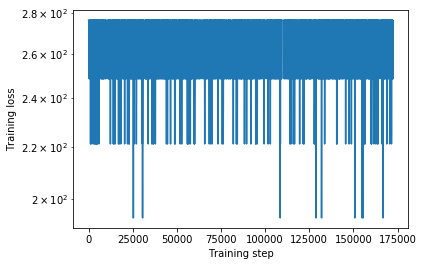

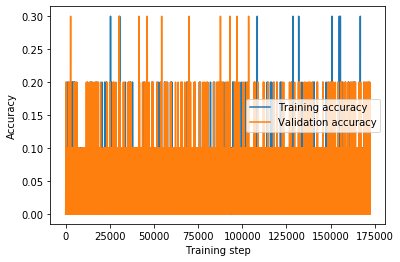

In [26]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()
# ======

## Exercise 6 - optimizers

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [27]:
# ======
# Create a neural network based on the code in the exercises above
# Modify the optimizer to find what works best
batch_size = 10
learning_rate = 0.00001
n_epochs = 100
print_every = 50
num_hidden = 100

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())

# Create additional hidden layers
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_3 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_4 = layer(num_hidden, num_hidden, activation=nn.ReLU())
layer_5 = layer(num_hidden, num_hidden, activation=nn.ReLU())

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax())

# create the optimizer
optimizer = optim.Adam(
    # Add all of the network weights for the three layers
    [layer_1.weight, layer_1.bias,
     layer_2.weight, layer_2.bias,
     layer_3.weight, layer_3.bias,
     layer_4.weight, layer_4.bias,
     layer_5.weight, layer_5.bias,
     layer_6.weight, layer_6.bias],
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        hidden_layer1 = layer_1(train_data_batch)
        # Apply your additional hidden layers
        hidden_layer2 = layer_2(hidden_layer1)
        hidden_layer3 = layer_3(hidden_layer2)
        hidden_layer4 = layer_4(hidden_layer3)
        hidden_layer5 = layer_5(hidden_layer4)
        output = layer_6(hidden_layer5)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_hidden1 = layer_1(valid_data_batch)
                    # Apply your additional hidden layers
                    valid_hidden2 = layer_2(valid_hidden1)
                    valid_hidden3 = layer_3(valid_hidden2)
                    valid_hidden4 = layer_4(valid_hidden3)
                    valid_hidden5 = layer_5(valid_hidden4)
                    
                    valid_output = layer_6(hidden_layer5)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np = np.concatenate(prediction_np.reshape(-1,1), axis=0)
                    labels_np = np.concatenate(valid_labels_batch.numpy().reshape(-1,1), axis=0)


                # compute the accuracy over the whole dataset
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

<ipython-input-13-dfdd7b4cad66>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.activation(output)


Step 50 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 700 loss

Step 5400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 5500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 5650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 5900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 5950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 6000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 

Step 10750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 10800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 10850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 10900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 10950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 11250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 11350 loss: 276.310 training accuracy: 0.000 validation acc

Step 16050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 16250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 16600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 16650 loss: 276.310 training accuracy: 0.000 validation acc

Step 21350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 21500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21750 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 21800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 21850 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 21900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 21950 loss: 276.310 training accuracy: 0.000 validation acc

Step 26650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 26950 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 27000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 27250 loss: 248.679 training accuracy: 0.100 validation acc

Step 31950 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 32000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32250 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 32300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 32550 loss: 248.679 training accuracy: 0.100 validation acc

Step 37250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 37400 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 37450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 37650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 37750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 37800 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 37850 loss: 276.310 training accuracy: 0.000 validation acc

Step 42550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 42650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 42750 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 42800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 42900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 42950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43000 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 43050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 43150 loss: 276.310 training accuracy: 0.000 validation acc

Step 47850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 47900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 47950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 48150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 48350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 48450 loss: 276.310 training accuracy: 0.000 validation acc

Step 53150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 53400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 53600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 53700 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 53750 loss: 276.310 training accuracy: 0.000 validation acc

Step 58450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58600 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 58650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 58900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 58950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 59050 loss: 276.310 training accuracy: 0.000 validation acc

Step 63750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 63800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 63850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 63900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 63950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 64350 loss: 248.679 training accuracy: 0.100 validation acc

Step 69050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69150 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 69200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69300 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 69350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 69550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 69650 loss: 276.310 training accuracy: 0.000 validation acc

Step 74350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 74400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 74600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 74950 loss: 276.310 training accuracy: 0.000 validation acc

Step 79650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 79700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 79750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 79800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 79850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 79900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 79950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 80250 loss: 276.310 training accuracy: 0.000 validation acc

Step 84950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 85550 loss: 276.310 training accuracy: 0.000 validation acc

Step 90250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 90350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90450 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 90500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90700 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 90750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 90800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 90850 loss: 276.310 training accuracy: 0.000 validation acc

Step 95550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95850 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 95900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 95950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 96150 loss: 276.310 training accuracy: 0.000 validation acc

Step 100800 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 100850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 100900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 100950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 101400 loss: 276.310 training accuracy: 0.000 v

Step 106000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 106550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 106600 loss: 276.310 training accuracy: 0.000 v

Step 111200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 111400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 111550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 111650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 111750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 111800 loss: 248.679 training accuracy: 0.100 v

Step 116400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 116450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116650 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 116700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 116900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 116950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 117000 loss: 276.310 training accuracy: 0.000 v

Step 121600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 121650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 121700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 121750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 121800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 121850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 121900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 121950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122100 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 122150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 122200 loss: 276.310 training accuracy: 0.000 v

Step 126800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 126850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 126900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 126950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 127400 loss: 276.310 training accuracy: 0.000 v

Step 132000 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 132050 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 132100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 132250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132500 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 132550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 132600 loss: 276.310 training accuracy: 0.000 v

Step 137200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 137400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.100 
Step 137600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 137800 loss: 248.679 training accuracy: 0.100 v

Step 142400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142550 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 142600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 142900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 142950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 143000 loss: 276.310 training accuracy: 0.000 v

Step 147600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 147650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 147700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 147750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 147800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 147850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 147900 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 147950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 148200 loss: 276.310 training accuracy: 0.000 v

Step 152800 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 152850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 152900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 152950 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 153350 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 153400 loss: 276.310 training accuracy: 0.000 v

Step 158000 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158050 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158100 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158150 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158200 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 158350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158400 loss: 221.048 training accuracy: 0.200 validation accuracy: 0.000 
Step 158450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 158600 loss: 276.310 training accuracy: 0.000 v

Step 163200 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 163250 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163300 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163350 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163750 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 163800 loss: 276.310 training accuracy: 0.000 v

Step 168400 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168450 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168500 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168550 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168600 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 168650 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168700 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168750 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 168800 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168850 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.100 
Step 168900 loss: 276.310 training accuracy: 0.000 validation accuracy: 0.000 
Step 168950 loss: 248.679 training accuracy: 0.100 validation accuracy: 0.000 
Step 169000 loss: 276.310 training accuracy: 0.000 v

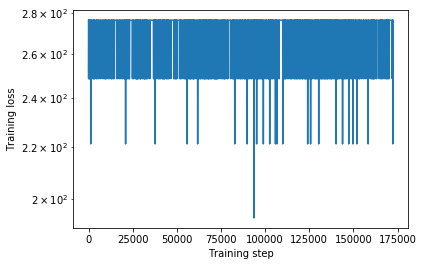

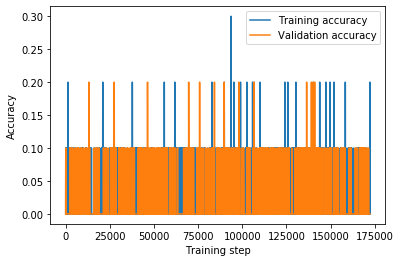

In [28]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()
# ======

### Discussion

1. How did the more complex networks you built compare to the simple network we started with?
2. Which was more useful -- adding _depth_ to your network or adding width?
3. Which optimizer performed best?
4. What had the biggest effect on performance: depth, width, or optimizer?

#### Re-Cap
1. Power of PyTorch is to allow us to setup the neural networks using nn.Module

2. We can use the same neural network over and over with different data without having to re-write the code.